# Group 7- Multi-Class Retinal Disease Classification Using OCT Imaging: A CNN-Based Approach

# InceptionV3- Soleman Hossain 2021682042

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import time
import numpy as np
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [11]:
# Paths
data_dir = 'dataset'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Basic preprocessing
image_size = 299
batch_size = 32

basic_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [3]:
train_ds = datasets.ImageFolder(train_dir, transform=basic_transform)
val_ds = datasets.ImageFolder(val_dir, transform=basic_transform)
test_ds = datasets.ImageFolder(test_dir, transform=basic_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

class_names = train_ds.classes
print("Classes:", class_names)

Classes: ['Age_related_Macular_Degeneration', 'Central_Serious_Retinopathy', 'Choroidal_Neovascularization', 'Diabetic_Macular_Edema', 'Diabetic_Retinopathy', 'Drusen', 'Macular_Hole', 'Normal']


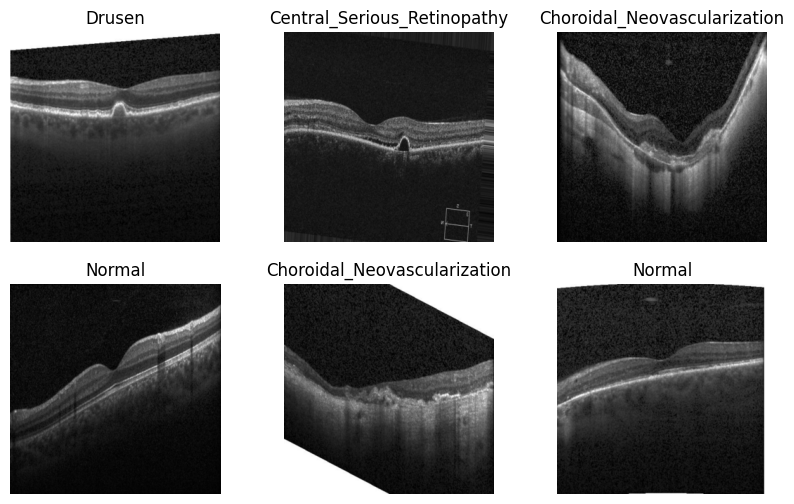

In [4]:
def show_batch(dl):
    images, labels = next(iter(dl))
    plt.figure(figsize=(10,6))
    for i in range(6):
        img = images[i].permute(1, 2, 0) * 0.5 + 0.5  # unnormalize
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.show()

show_batch(train_loader)


In [36]:
model = models.inception_v3(weights='Inception_V3_Weights.IMAGENET1K_V1')
for param in model.parameters():
    param.requires_grad = False

num_classes = len(class_names)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [37]:
from tqdm import tqdm
import time

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    since = time.time()

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss, running_corrects = 0.0, 0
        total_samples = 0

        loop = tqdm(train_loader, desc="Training", leave=True)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs, aux_outputs = model(inputs)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4 * loss2
            loss.backward()
            optimizer.step()

            # Metrics
            batch_size = inputs.size(0)
            total_samples += batch_size
            running_loss += loss.item() * batch_size
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels).item()

            # Update progress bar with live loss & accuracy
            current_loss = running_loss / total_samples
            current_acc = running_corrects / total_samples
            loop.set_postfix(loss=f"{current_loss:.4f}", acc=f"{current_acc:.4f}")

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        # Validation
        model.eval()
        val_running_loss, val_running_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels).item()

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects / len(val_loader.dataset)
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        # Print per-epoch summary
        print(f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
        print(f"Val   Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.4f}")

    total_time = time.time() - since
    print(f"\nTraining completed in {total_time:.0f} seconds")

    return train_loss, val_loss, train_acc, val_acc, total_time


In [38]:
train_loss, val_loss, train_acc, val_acc, training_time = train_model(
    model, criterion, optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=5
)



Epoch 1/5


Training: 100%|██████████| 575/575 [06:27<00:00,  1.48it/s, acc=0.4281, loss=2.2069]


Train Loss: 2.2069, Acc: 0.4281
Val   Loss: 1.3709, Acc: 0.6554

Epoch 2/5


Training: 100%|██████████| 575/575 [07:01<00:00,  1.36it/s, acc=0.6040, loss=1.5913]


Train Loss: 1.5913, Acc: 0.6040
Val   Loss: 1.1220, Acc: 0.7164

Epoch 3/5


Training: 100%|██████████| 575/575 [06:38<00:00,  1.44it/s, acc=0.6579, loss=1.3617]


Train Loss: 1.3617, Acc: 0.6579
Val   Loss: 0.9952, Acc: 0.7361

Epoch 4/5


Training: 100%|██████████| 575/575 [06:36<00:00,  1.45it/s, acc=0.6795, loss=1.2288]


Train Loss: 1.2288, Acc: 0.6795
Val   Loss: 0.9106, Acc: 0.7425

Epoch 5/5


Training: 100%|██████████| 575/575 [06:44<00:00,  1.42it/s, acc=0.6970, loss=1.1533]


Train Loss: 1.1533, Acc: 0.6970
Val   Loss: 0.8488, Acc: 0.7432

Training completed in 2292 seconds


### That below model loading cell is optional. You can ignore it. Don't run thie cell = preferable

In [39]:
# Define a filename for saving the model
model_save_path = "InceptionV3.pth"

# Save the entire model state (recommended)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss,
    'train_acc': train_acc,
    'val_acc': val_acc,
    'training_time': training_time,
    'num_classes': num_classes,
    'class_names': class_names,
    'batch_size': batch_size
}, model_save_path)

print(f"\nModel saved to {model_save_path}")


Model saved to InceptionV3.pth


Classification Report:

                                  precision    recall  f1-score   support

Age_related_Macular_Degeneration       1.00      1.00      1.00       350
     Central_Serious_Retinopathy       0.82      0.77      0.79       350
    Choroidal_Neovascularization       0.76      0.62      0.68       350
          Diabetic_Macular_Edema       0.62      0.67      0.65       350
            Diabetic_Retinopathy       0.67      0.85      0.75       350
                          Drusen       0.63      0.62      0.62       350
                    Macular_Hole       0.86      0.70      0.77       350
                          Normal       0.71      0.79      0.74       350

                        accuracy                           0.75      2800
                       macro avg       0.76      0.75      0.75      2800
                    weighted avg       0.76      0.75      0.75      2800


Total Accuracy:  0.7507
Total Precision: 0.7584
Total Recall:    0.7507
Total F1 Sco

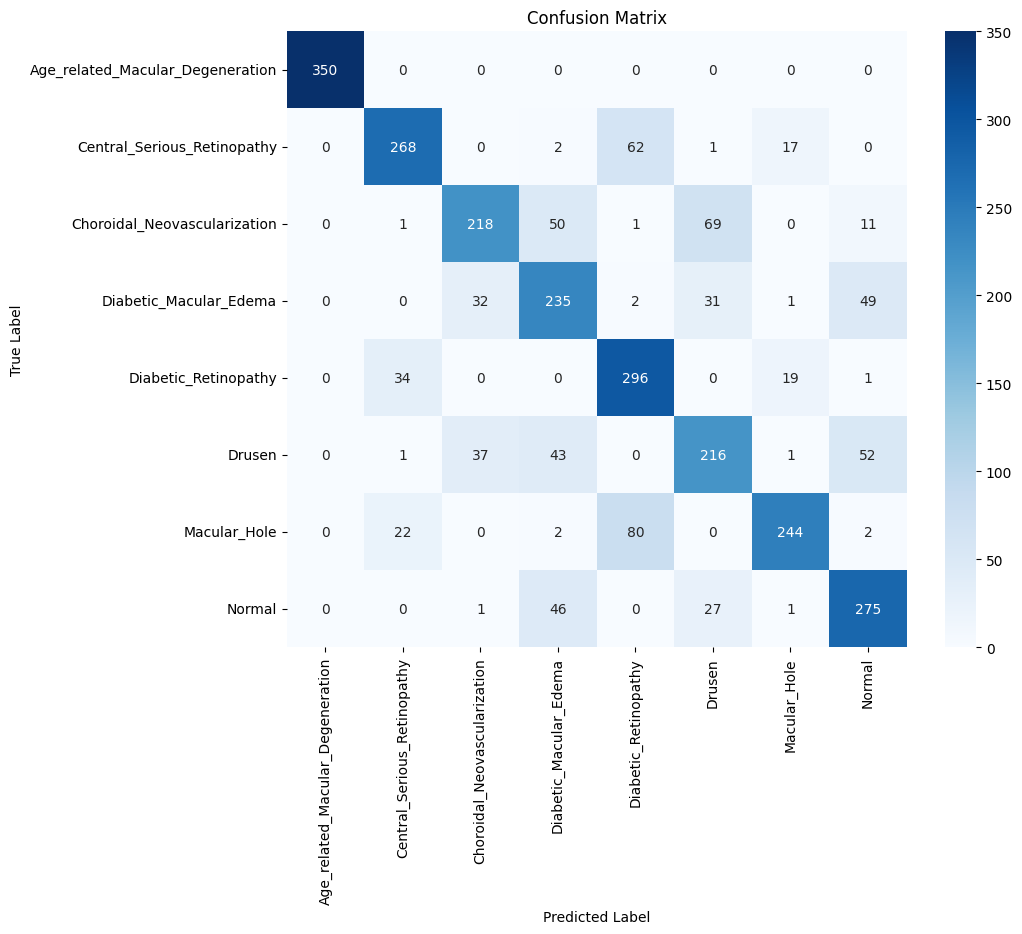

Model size: 92.95 MB
Total parameters: 24,365,808


In [43]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import torch

def evaluate_model(model, dataloader):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.numpy())

    # Classification Report
    report = classification_report(targets, preds, target_names=class_names, output_dict=True)
    print("Classification Report:\n")
    print(classification_report(targets, preds, target_names=class_names))

    # Precision, Recall, F1 (weighted average)
    precision, recall, f1, _ = precision_recall_fscore_support(targets, preds, average='weighted')
    accuracy = accuracy_score(targets, preds)
    print(f"\nTotal Accuracy:  {accuracy:.4f}")
    print(f"Total Precision: {precision:.4f}")
    print(f"Total Recall:    {recall:.4f}")
    print(f"Total F1 Score:  {f1:.4f}")

    # Accuracy
    

    # Confusion Matrix
    cm = confusion_matrix(targets, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Run Evaluation
evaluate_model(model, test_loader)

# Model size and parameter count
def model_size_mb(model):
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    return param_size / 1024**2  # MB

print(f"Model size: {model_size_mb(model):.2f} MB")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

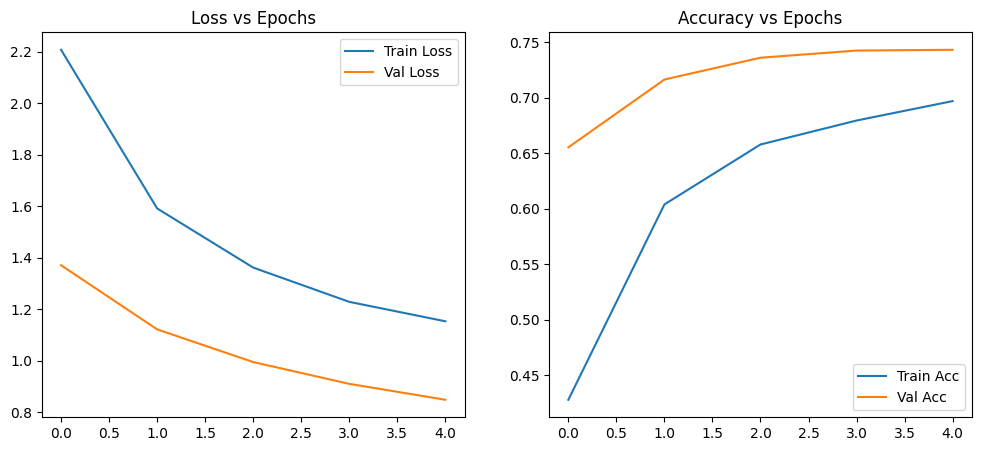

In [44]:
epochs = len(train_loss)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_loss, label="Train Loss")
plt.plot(range(epochs), val_loss, label="Val Loss")
plt.title("Loss vs Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_acc, label="Train Acc")
plt.plot(range(epochs), val_acc, label="Val Acc")
plt.title("Accuracy vs Epochs")
plt.legend()

plt.show()


In [45]:
augmented_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Apply augmentation to train set only
train_ds_aug = datasets.ImageFolder(train_dir, transform=augmented_transform)
train_loader_aug = DataLoader(train_ds_aug, batch_size=batch_size, shuffle=True)

In [46]:
# Reset model
model_aug = models.inception_v3(weights='Inception_V3_Weights.IMAGENET1K_V1')
for param in model_aug.parameters():
    param.requires_grad = False

model_aug.fc = nn.Linear(model_aug.fc.in_features, num_classes)
model_aug.AuxLogits.fc = nn.Linear(model_aug.AuxLogits.fc.in_features, num_classes)
model_aug = model_aug.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_aug = optim.Adam(model_aug.parameters(), lr=1e-4)

In [47]:
from tqdm import tqdm  # use terminal-style tqdm
import time

def train_model(model, criterion, optimizer, epochs, train_loader, val_loader):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    since = time.time()

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 30)

        # Training Phase
        model.train()
        running_loss, running_corrects = 0.0, 0
        total_samples = 0

        loop = tqdm(train_loader, desc="Training", leave=True)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Inception model: main + aux output
            outputs, aux_outputs = model(inputs)
            loss1 = criterion(outputs, labels)
            loss2 = criterion(aux_outputs, labels)
            loss = loss1 + 0.4 * loss2
            loss.backward()
            optimizer.step()

            batch_size = inputs.size(0)
            total_samples += batch_size
            running_loss += loss.item() * batch_size
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels).item()

            # Live update loss & accuracy
            current_loss = running_loss / total_samples
            current_acc = running_corrects / total_samples
            loop.set_postfix(loss=f"{current_loss:.4f}", acc=f"{current_acc:.4f}")

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        # Validation Phase
        model.eval()
        val_running_loss, val_running_corrects = 0.0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels).item()

        val_loss_epoch = val_running_loss / len(val_loader.dataset)
        val_acc_epoch = val_running_corrects / len(val_loader.dataset)
        val_loss.append(val_loss_epoch)
        val_acc.append(val_acc_epoch)

        print(f"Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")
        print(f"Val   Loss: {val_loss_epoch:.4f} | Val   Acc: {val_acc_epoch:.4f}")

    total_time = time.time() - since
    print(f"\nTraining completed in {total_time:.2f} seconds.")
    return train_loss, val_loss, train_acc, val_acc, total_time


In [48]:
train_loss_aug, val_loss_aug, train_acc_aug, val_acc_aug, time_aug = train_model(
    model_aug, criterion, optimizer_aug,
    epochs=5,
    train_loader=train_loader_aug,
    val_loader=val_loader
)



Epoch 1/5
------------------------------


Training: 100%|██████████| 575/575 [11:11<00:00,  1.17s/it, acc=0.3909, loss=2.3297]


Train Loss: 2.3297 | Train Acc: 0.3909
Val   Loss: 1.5012 | Val   Acc: 0.5779

Epoch 2/5
------------------------------


Training: 100%|██████████| 575/575 [11:15<00:00,  1.18s/it, acc=0.5579, loss=1.7584]


Train Loss: 1.7584 | Train Acc: 0.5579
Val   Loss: 1.2485 | Val   Acc: 0.6671

Epoch 3/5
------------------------------


Training: 100%|██████████| 575/575 [11:25<00:00,  1.19s/it, acc=0.6136, loss=1.5294]


Train Loss: 1.5294 | Train Acc: 0.6136
Val   Loss: 1.1252 | Val   Acc: 0.6518

Epoch 4/5
------------------------------


Training: 100%|██████████| 575/575 [11:24<00:00,  1.19s/it, acc=0.6391, loss=1.3915]


Train Loss: 1.3915 | Train Acc: 0.6391
Val   Loss: 1.0342 | Val   Acc: 0.6971

Epoch 5/5
------------------------------


Training: 100%|██████████| 575/575 [11:25<00:00,  1.19s/it, acc=0.6536, loss=1.3023]


Train Loss: 1.3023 | Train Acc: 0.6536
Val   Loss: 0.9670 | Val   Acc: 0.6943

Training completed in 3708.18 seconds.


### That below model loading cell is optional. You can ignore it. Don't run thie cell = preferable

In [ ]:
# Define a filename for saving the model
model_save_path = "InceptionV3_aug.pth"

# Save the entire model state (recommended)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss,
    'train_acc': train_acc,
    'val_acc': val_acc,
    'training_time': training_time,
    'num_classes': num_classes,
    'class_names': class_names,
    'batch_size': batch_size
}, model_save_path)

print(f"\nModel saved to {model_save_path}")


Model saved to InceptionV3_aug.pth


Classification Report:

                                  precision    recall  f1-score   support

Age_related_Macular_Degeneration       1.00      0.97      0.99       350
     Central_Serious_Retinopathy       0.66      0.89      0.76       350
    Choroidal_Neovascularization       0.69      0.59      0.63       350
          Diabetic_Macular_Edema       0.74      0.40      0.52       350
            Diabetic_Retinopathy       0.80      0.57      0.67       350
                          Drusen       0.59      0.48      0.53       350
                    Macular_Hole       0.79      0.78      0.79       350
                          Normal       0.52      0.92      0.66       350

                        accuracy                           0.70      2800
                       macro avg       0.72      0.70      0.69      2800
                    weighted avg       0.72      0.70      0.69      2800


Total Accuracy:  0.7007
Total Precision: 0.7242
Total Recall:    0.7007
Total F1 Sco

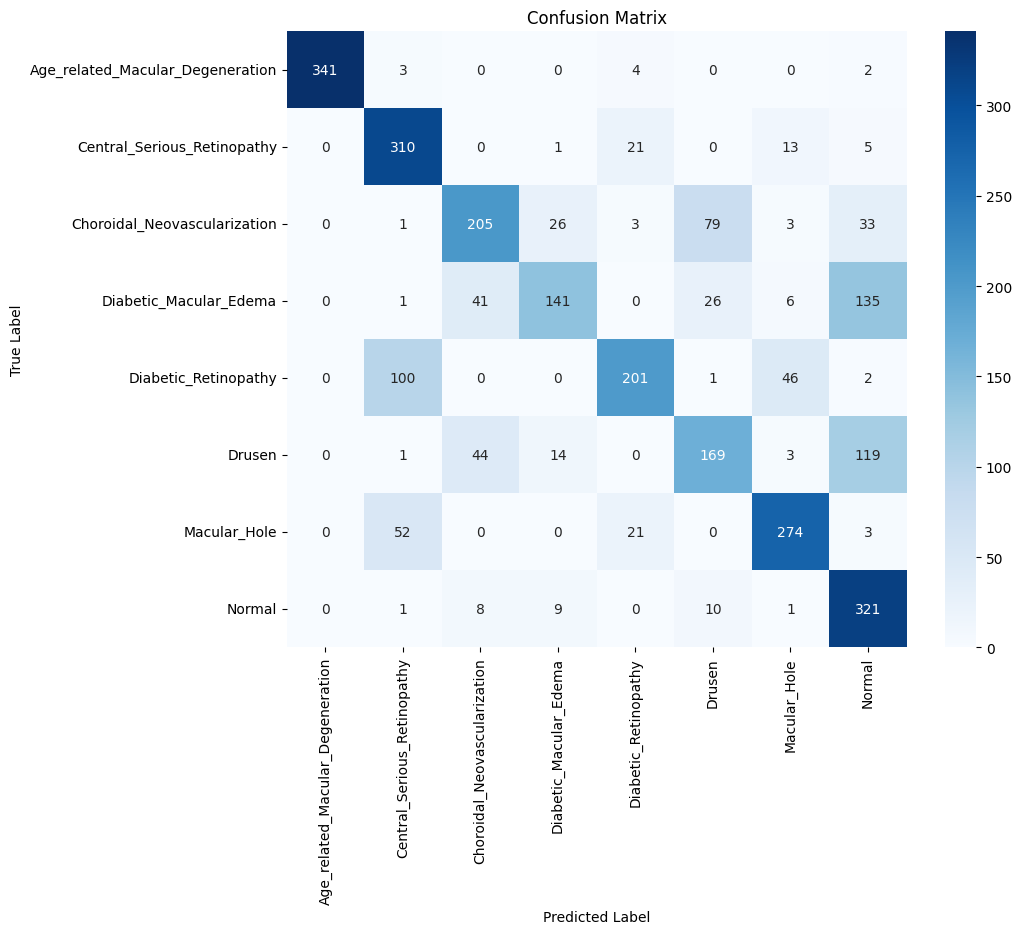

Model size: 92.95 MB
Total parameters: 24,365,808


In [56]:
evaluate_model(model_aug, test_loader)

print(f"Model size: {model_size_mb(model_aug):.2f} MB")
print(f"Total parameters: {sum(p.numel() for p in model_aug.parameters()):,}")


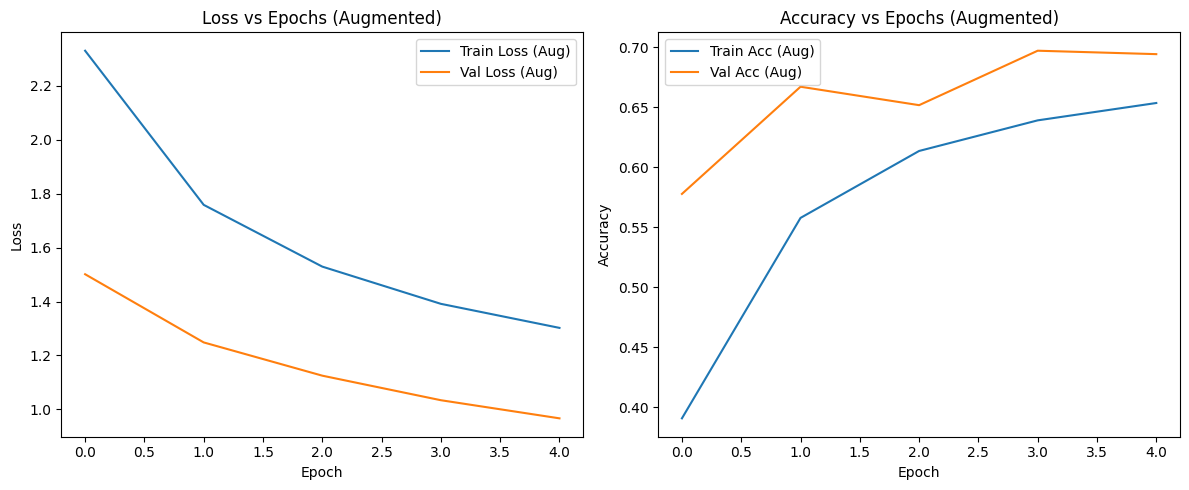

In [57]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_aug, label="Train Loss (Aug)")
plt.plot(val_loss_aug, label="Val Loss (Aug)")
plt.title("Loss vs Epochs (Augmented)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_aug, label="Train Acc (Aug)")
plt.plot(val_acc_aug, label="Val Acc (Aug)")
plt.title("Accuracy vs Epochs (Augmented)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


# EfficientNET - S. T. A. Mahmud Tonmoy 2011105042

In [28]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.nn as nn
import torch.optim as optim

# Load pretrained EfficientNet
model_eff = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

# Freeze all layers
for param in model_eff.parameters():
    param.requires_grad = False

# Replace final classifier
in_features = model_eff.classifier[1].in_features
model_eff.classifier[1] = nn.Linear(in_features, len(class_names))

model_eff = model_eff.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_eff = optim.Adam(model_eff.parameters(), lr=1e-4)


In [29]:
def train_model_eff(model, criterion, optimizer, train_loader, val_loader, num_epochs=5):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    since = time.time()

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss, running_corrects = 0.0, 0
        total_samples = 0

        loop = tqdm(train_loader, desc="Training", leave=True)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_size = inputs.size(0)
            total_samples += batch_size
            running_loss += loss.item() * batch_size
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels).item()

            loop.set_postfix(
                loss=f"{running_loss/total_samples:.4f}",
                acc=f"{running_corrects/total_samples:.4f}"
            )

        # Epoch stats
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        # Validation
        model.eval()
        val_running_loss, val_running_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels).item()

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects / len(val_loader.dataset)
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        print(f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
        print(f"Val   Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.4f}")

    total_time = time.time() - since
    print(f"\nTraining completed in {total_time:.0f} seconds")
    return train_loss, val_loss, train_acc, val_acc, total_time


In [31]:
train_loss_eff, val_loss_eff, train_acc_eff, val_acc_eff, training_time_eff = train_model_eff(
    model_eff, criterion, optimizer_eff,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=5
)



Epoch 1/5


Training: 100%|██████████| 575/575 [04:55<00:00,  1.94it/s, acc=0.5975, loss=1.4298]


Train Loss: 1.4298, Acc: 0.5975
Val   Loss: 1.0041, Acc: 0.7593

Epoch 2/5


Training: 100%|██████████| 575/575 [04:09<00:00,  2.30it/s, acc=0.7469, loss=0.9428]


Train Loss: 0.9428, Acc: 0.7469
Val   Loss: 0.7730, Acc: 0.7904

Epoch 3/5


Training: 100%|██████████| 575/575 [04:37<00:00,  2.07it/s, acc=0.7738, loss=0.7846]


Train Loss: 0.7846, Acc: 0.7738
Val   Loss: 0.6661, Acc: 0.7918

Epoch 4/5


Training: 100%|██████████| 575/575 [04:25<00:00,  2.17it/s, acc=0.7850, loss=0.6984]


Train Loss: 0.6984, Acc: 0.7850
Val   Loss: 0.5946, Acc: 0.8079

Epoch 5/5


Training: 100%|██████████| 575/575 [04:14<00:00,  2.26it/s, acc=0.7940, loss=0.6443]


Train Loss: 0.6443, Acc: 0.7940
Val   Loss: 0.5506, Acc: 0.8236

Training completed in 1543 seconds


### That below model loading cell is optional. You can ignore it. Don't run thie cell = preferable

In [33]:
model_save_path = "EfficientNet_B0.pth"

torch.save({
    'model_state_dict': model_eff.state_dict(),
    'optimizer_state_dict': optimizer_eff.state_dict(),
    'train_loss': train_loss_eff,
    'val_loss': val_loss_eff,
    'train_acc': train_acc_eff,
    'val_acc': val_acc_eff,
    'training_time': training_time_eff,
    'num_classes': num_classes,
    'class_names': class_names,
    'batch_size': batch_size
}, model_save_path)

print(f"\nModel saved to {model_save_path}")



Model saved to EfficientNet_B0.pth


Classification Report:

                                  precision    recall  f1-score   support

Age_related_Macular_Degeneration       1.00      1.00      1.00       350
     Central_Serious_Retinopathy       0.92      0.96      0.94       350
    Choroidal_Neovascularization       0.77      0.72      0.74       350
          Diabetic_Macular_Edema       0.79      0.66      0.72       350
            Diabetic_Retinopathy       0.86      0.88      0.87       350
                          Drusen       0.65      0.64      0.65       350
                    Macular_Hole       0.93      0.87      0.90       350
                          Normal       0.68      0.85      0.76       350

                        accuracy                           0.82      2800
                       macro avg       0.82      0.82      0.82      2800
                    weighted avg       0.82      0.82      0.82      2800


Total Accuracy:  0.8218
Total Precision: 0.8247
Total Recall:    0.8218
Total F1 Sco

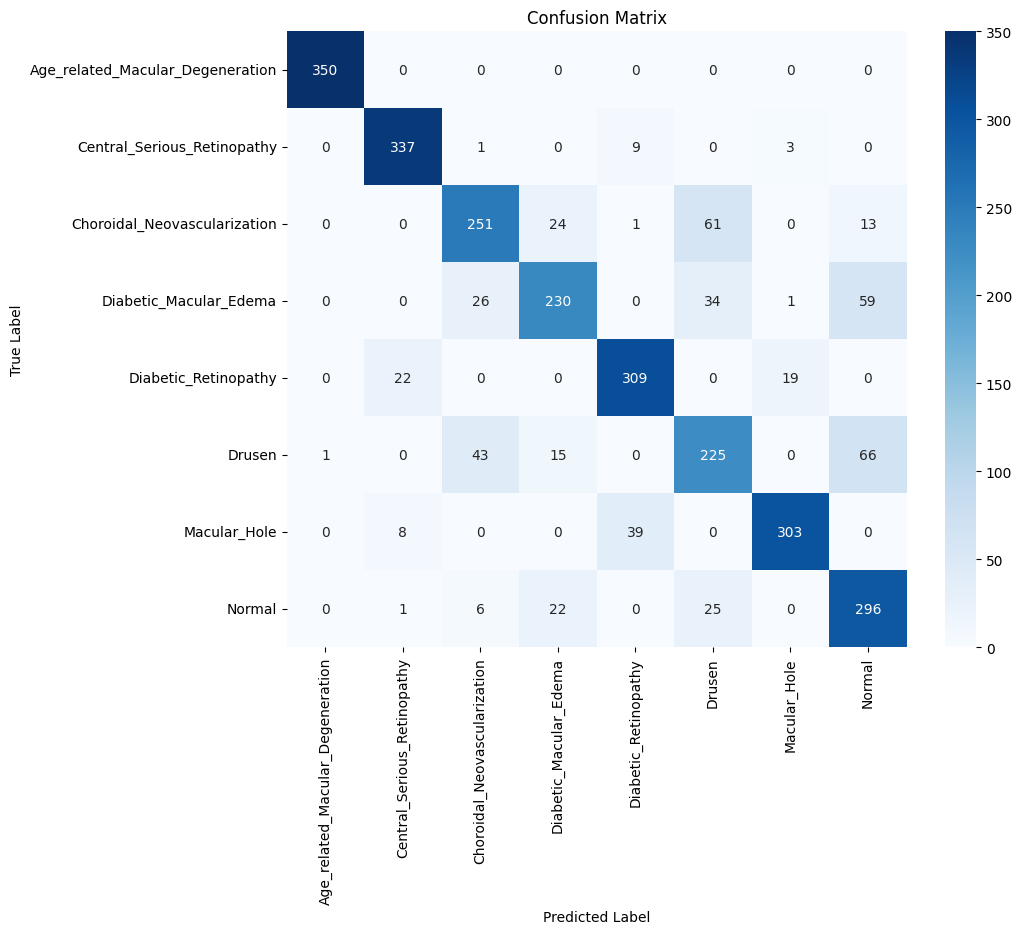


Model size: 15.33 MB
Total parameters: 4,017,796


In [38]:
def evaluate_model(model, dataloader):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.numpy())

    # Classification report
    print("Classification Report:\n")
    print(classification_report(targets, preds, target_names=class_names))

    # Metrics
    precision, recall, f1, _ = precision_recall_fscore_support(targets, preds, average='weighted', zero_division=0)
    accuracy = accuracy_score(targets, preds)
    print(f"\nTotal Accuracy:  {accuracy:.4f}")
    print(f"Total Precision: {precision:.4f}")
    print(f"Total Recall:    {recall:.4f}")
    print(f"Total F1 Score:  {f1:.4f}")

    # Confusion matrix
    cm = confusion_matrix(targets, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


def model_size_mb(model):
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    return param_size / 1024**2  # MB


evaluate_model(model_eff, test_loader)

print(f"\nModel size: {model_size_mb(model_eff):.2f} MB")
print(f"Total parameters: {sum(p.numel() for p in model_eff.parameters()):,}")



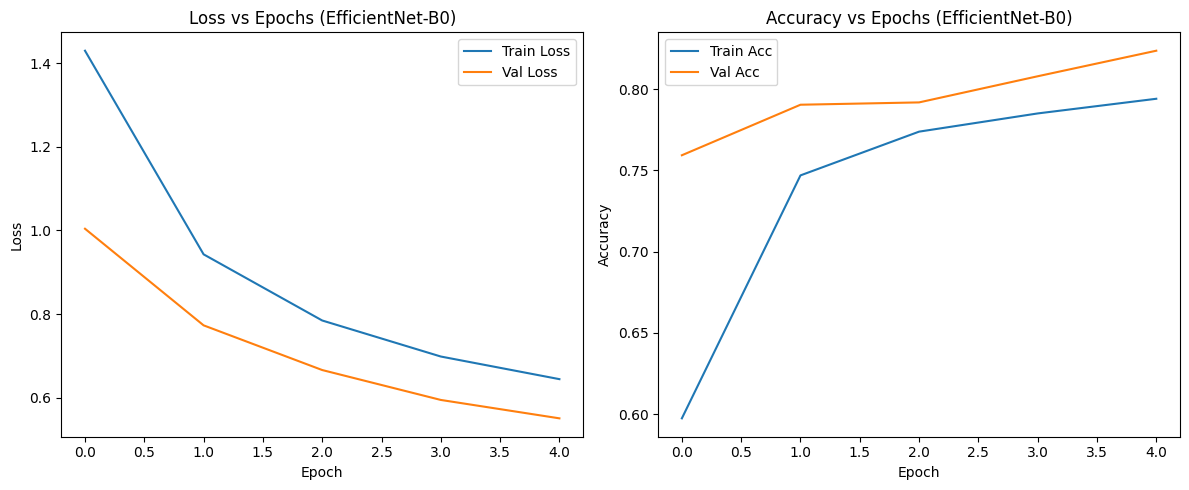

In [39]:
epochs = len(train_loss_eff)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_loss_eff, label="Train Loss")
plt.plot(range(epochs), val_loss_eff, label="Val Loss")
plt.title("Loss vs Epochs (EfficientNet-B0)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_acc_eff, label="Train Acc")
plt.plot(range(epochs), val_acc_eff, label="Val Acc")
plt.title("Accuracy vs Epochs (EfficientNet-B0)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [46]:
augmented_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_ds_aug = datasets.ImageFolder(train_dir, transform=augmented_transform)
train_loader_aug = DataLoader(train_ds_aug, batch_size=batch_size, shuffle=True)


In [47]:
model_eff_aug = efficientnet_b0(weights='EfficientNet_B0_Weights.IMAGENET1K_V1')

# Freeze layers
for param in model_eff_aug.parameters():
    param.requires_grad = False

# Replace classifier
in_features = model_eff_aug.classifier[1].in_features
model_eff_aug.classifier[1] = nn.Linear(in_features, len(class_names))

model_eff_aug = model_eff_aug.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_eff_aug = optim.Adam(model_eff_aug.parameters(), lr=1e-4)


In [52]:
train_loss_eff_aug, val_loss_eff_aug, train_acc_eff_aug, val_acc_eff_aug, time_eff_aug = train_model_efficientnet(
    model_eff_aug, criterion, optimizer_eff_aug,
    train_loader=train_loader_aug,
    val_loader=val_loader,
    num_epochs=5
)



Epoch 1/5


Training: 100%|██████████| 575/575 [06:52<00:00,  1.39it/s, acc=0.5813, loss=1.5019]


Train Loss: 1.5019, Acc: 0.5813
Val   Loss: 1.1461, Acc: 0.7032

Epoch 2/5


Training: 100%|██████████| 575/575 [06:46<00:00,  1.41it/s, acc=0.7211, loss=1.0275]


Train Loss: 1.0275, Acc: 0.7211
Val   Loss: 0.8805, Acc: 0.7475

Epoch 3/5


Training: 100%|██████████| 575/575 [06:52<00:00,  1.39it/s, acc=0.7466, loss=0.8612]


Train Loss: 0.8612, Acc: 0.7466
Val   Loss: 0.7464, Acc: 0.7718

Epoch 4/5


Training: 100%|██████████| 575/575 [06:25<00:00,  1.49it/s, acc=0.7631, loss=0.7709]


Train Loss: 0.7709, Acc: 0.7631
Val   Loss: 0.7079, Acc: 0.7682

Epoch 5/5


Training: 100%|██████████| 575/575 [06:36<00:00,  1.45it/s, acc=0.7653, loss=0.7201]


Train Loss: 0.7201, Acc: 0.7653
Val   Loss: 0.6378, Acc: 0.7839

Training completed in 2210 seconds


### That below model loading cell is optional. You can ignore it. Don't run thie cell = preferable

In [60]:
model_save_path = "EfficientNetB0_aug.pth"

torch.save({
    'model_state_dict': model_eff_aug.state_dict(),
    'optimizer_state_dict': optimizer_eff_aug.state_dict(),
    'train_loss': train_loss_eff_aug,
    'val_loss': val_loss_eff_aug,
    'train_acc': train_acc_eff_aug,
    'val_acc': val_acc_eff_aug,
    'training_time': time_eff_aug,
    'num_classes': num_classes,
    'class_names': class_names,
    'batch_size': batch_size
}, model_save_path)

print(f"\nModel saved to {model_save_path}")



Model saved to EfficientNetB0_aug.pth


Classification Report:

                                  precision    recall  f1-score   support

Age_related_Macular_Degeneration       0.97      0.99      0.98       350
     Central_Serious_Retinopathy       0.90      0.87      0.88       350
    Choroidal_Neovascularization       0.83      0.63      0.71       350
          Diabetic_Macular_Edema       0.77      0.60      0.68       350
            Diabetic_Retinopathy       0.77      0.88      0.82       350
                          Drusen       0.68      0.41      0.51       350
                    Macular_Hole       0.88      0.87      0.88       350
                          Normal       0.55      0.95      0.69       350

                        accuracy                           0.77      2800
                       macro avg       0.79      0.77      0.77      2800
                    weighted avg       0.79      0.77      0.77      2800


Total Accuracy:  0.7746
Total Precision: 0.7926
Total Recall:    0.7746
Total F1 Sco

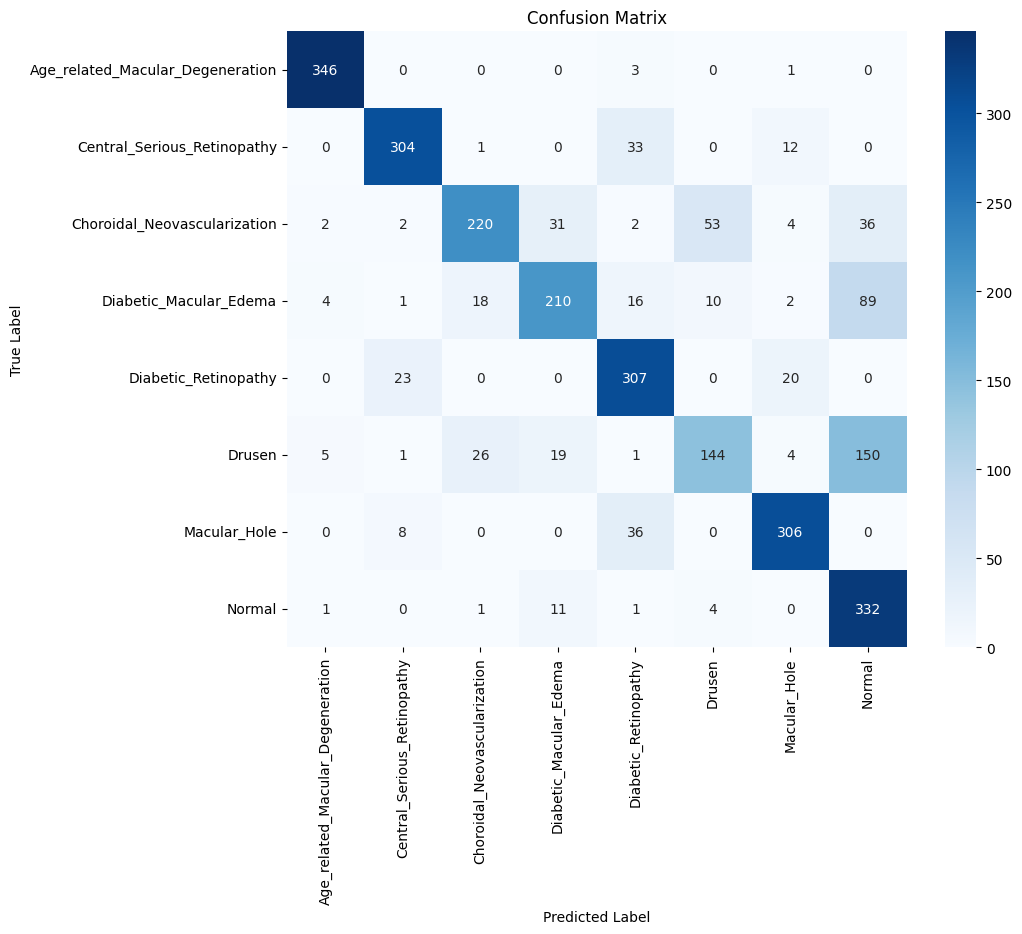

Model size: 15.33 MB
Total parameters: 4,017,796


In [61]:
evaluate_model(model_eff_aug, test_loader)

print(f"Model size: {model_size_mb(model_eff_aug):.2f} MB")
print(f"Total parameters: {sum(p.numel() for p in model_eff_aug.parameters()):,}")


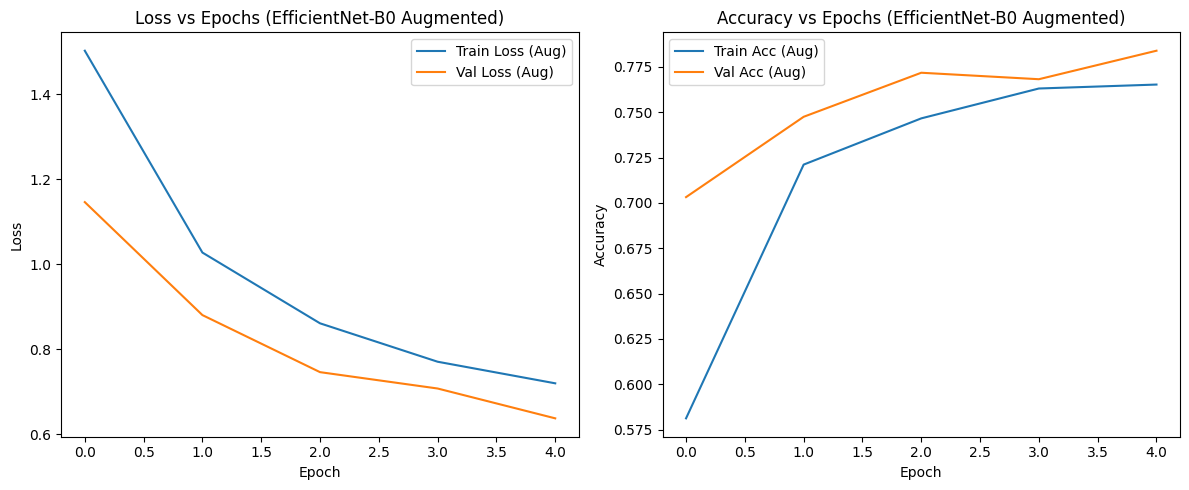

In [62]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_eff_aug, label="Train Loss (Aug)")
plt.plot(val_loss_eff_aug, label="Val Loss (Aug)")
plt.title("Loss vs Epochs (EfficientNet-B0 Augmented)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_eff_aug, label="Train Acc (Aug)")
plt.plot(val_acc_eff_aug, label="Val Acc (Aug)")
plt.title("Accuracy vs Epochs (EfficientNet-B0 Augmented)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


# RestNET18- Sihab Mahmud 21121660642

In [69]:
from torchvision.models import resnet18

model_res = resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')

# Freeze all layers
for param in model_res.parameters():
    param.requires_grad = False

# Replace final FC layer
in_features = model_res.fc.in_features
model_res.fc = nn.Linear(in_features, len(class_names))

model_res = model_res.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_res = optim.Adam(model_res.parameters(), lr=1e-4)


In [70]:
from tqdm import tqdm
import time

def train_model_resnet(model, criterion, optimizer, train_loader, val_loader, num_epochs=5):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    since = time.time()

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss, running_corrects = 0.0, 0
        total_samples = 0

        loop = tqdm(train_loader, desc="Training", leave=True)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_size = inputs.size(0)
            total_samples += batch_size
            running_loss += loss.item() * batch_size
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels).item()

            current_loss = running_loss / total_samples
            current_acc = running_corrects / total_samples
            loop.set_postfix(loss=f"{current_loss:.4f}", acc=f"{current_acc:.4f}")

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        # Validation
        model.eval()
        val_running_loss, val_running_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels).item()

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects / len(val_loader.dataset)
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        print(f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
        print(f"Val   Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.4f}")

    total_time = time.time() - since
    print(f"\nTraining completed in {total_time:.0f} seconds")
    return train_loss, val_loss, train_acc, val_acc, total_time


In [72]:
train_loss_res, val_loss_res, train_acc_res, val_acc_res, training_time_res = train_model_resnet(
    model_res, criterion, optimizer_res,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=5
)



Epoch 1/5


Training: 100%|██████████| 575/575 [05:59<00:00,  1.60it/s, acc=0.4567, loss=1.5696]


Train Loss: 1.5696, Acc: 0.4567
Val   Loss: 1.2348, Acc: 0.6004

Epoch 2/5


Training: 100%|██████████| 575/575 [05:28<00:00,  1.75it/s, acc=0.6479, loss=1.1315]


Train Loss: 1.1315, Acc: 0.6479
Val   Loss: 0.9991, Acc: 0.7204

Epoch 3/5


Training: 100%|██████████| 575/575 [05:30<00:00,  1.74it/s, acc=0.7203, loss=0.9670]


Train Loss: 0.9670, Acc: 0.7203
Val   Loss: 0.8784, Acc: 0.7532

Epoch 4/5


Training: 100%|██████████| 575/575 [05:26<00:00,  1.76it/s, acc=0.7443, loss=0.8692]


Train Loss: 0.8692, Acc: 0.7443
Val   Loss: 0.7961, Acc: 0.7789

Epoch 5/5


Training: 100%|██████████| 575/575 [05:26<00:00,  1.76it/s, acc=0.7612, loss=0.7996]


Train Loss: 0.7996, Acc: 0.7612
Val   Loss: 0.7387, Acc: 0.7939

Training completed in 1919 seconds


### That below model loading cell is optional. You can ignore it. Don't run thie cell = preferable

In [ ]:
# Define a filename for saving the model
model_save_path = "EfficientNet_aug.pth"


# Save the entire model state (recommended)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss,
    'train_acc': train_acc,
    'val_acc': val_acc,
    'training_time': training_time,
    'num_classes': num_classes,
    'class_names': class_names,
    'batch_size': batch_size
}, model_save_path)

print(f"\nModel saved to {model_save_path}")

Classification Report:

                                  precision    recall  f1-score   support

Age_related_Macular_Degeneration       1.00      1.00      1.00       350
     Central_Serious_Retinopathy       0.91      0.97      0.94       350
    Choroidal_Neovascularization       0.76      0.72      0.74       350
          Diabetic_Macular_Edema       0.79      0.72      0.75       350
            Diabetic_Retinopathy       0.87      0.86      0.86       350
                          Drusen       0.72      0.64      0.68       350
                    Macular_Hole       0.91      0.87      0.89       350
                          Normal       0.69      0.87      0.77       350

                        accuracy                           0.83      2800
                       macro avg       0.83      0.83      0.83      2800
                    weighted avg       0.83      0.83      0.83      2800


Total Accuracy:  0.8304
Total Precision: 0.8320
Total Recall:    0.8304
Total F1 Sco

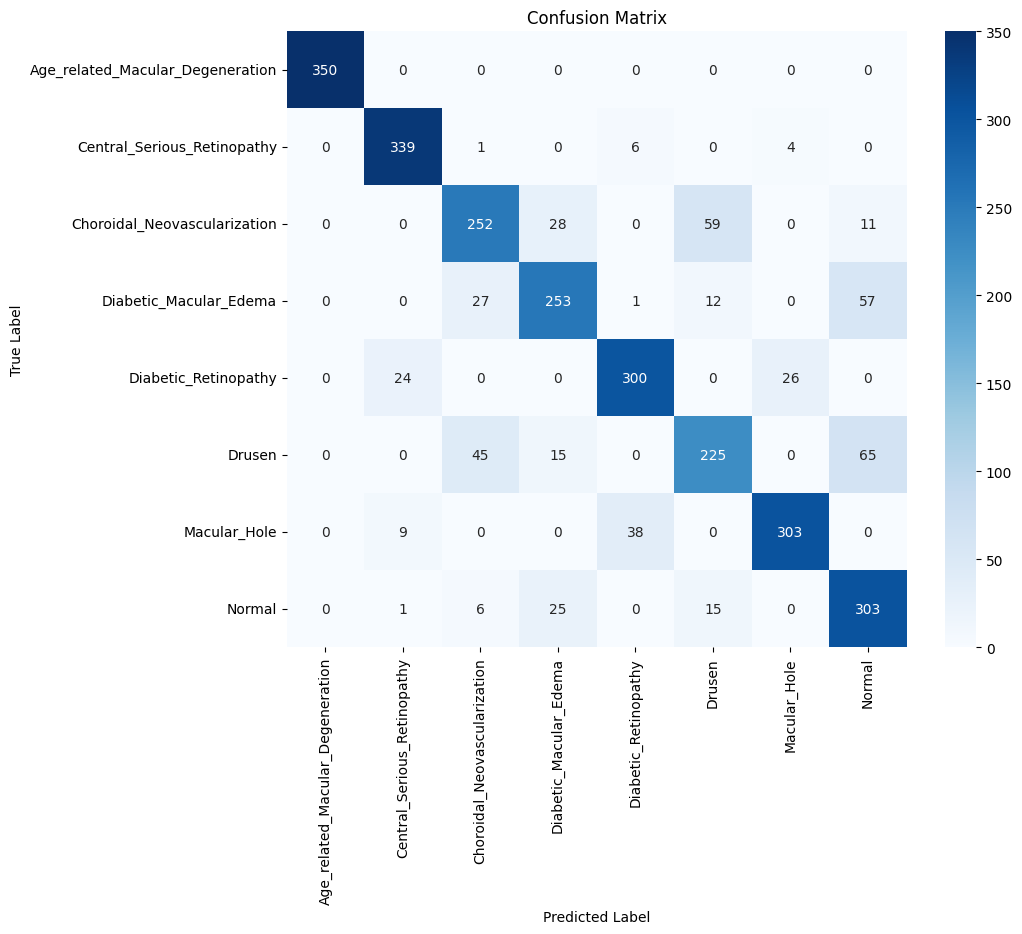

Model size: 15.33 MB
Total parameters: 4,017,796


In [74]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import torch

def evaluate_model(model, dataloader):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.numpy())

    # Classification Report
    report = classification_report(targets, preds, target_names=class_names, output_dict=True)
    print("Classification Report:\n")
    print(classification_report(targets, preds, target_names=class_names))

    # Precision, Recall, F1 (weighted average)
    precision, recall, f1, _ = precision_recall_fscore_support(targets, preds, average='weighted')
    accuracy = accuracy_score(targets, preds)
    print(f"\nTotal Accuracy:  {accuracy:.4f}")
    print(f"Total Precision: {precision:.4f}")
    print(f"Total Recall:    {recall:.4f}")
    print(f"Total F1 Score:  {f1:.4f}")

    # Accuracy
    

    # Confusion Matrix
    cm = confusion_matrix(targets, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Run Evaluation
evaluate_model(model, test_loader)

# Model size and parameter count
def model_size_mb(model):
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    return param_size / 1024**2  # MB

print(f"Model size: {model_size_mb(model):.2f} MB")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

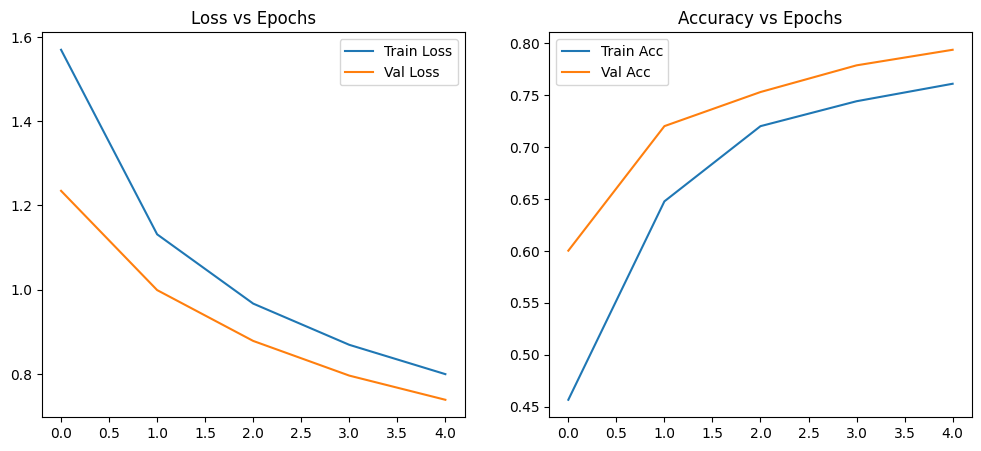

In [75]:
epochs = len(train_loss_res)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_loss_res, label="Train Loss")
plt.plot(range(epochs), val_loss_res, label="Val Loss")
plt.title("Loss vs Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_acc_res, label="Train Acc")
plt.plot(range(epochs), val_acc_res, label="Val Acc")
plt.title("Accuracy vs Epochs")
plt.legend()

plt.show()


In [76]:
augmented_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_ds_aug = datasets.ImageFolder(train_dir, transform=augmented_transform)
train_loader_aug = DataLoader(train_ds_aug, batch_size=batch_size, shuffle=True)


In [77]:
model_res_aug = resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
for param in model_res_aug.parameters():
    param.requires_grad = False

in_features = model_res_aug.fc.in_features
model_res_aug.fc = nn.Linear(in_features, len(class_names))
model_res_aug = model_res_aug.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_res_aug = optim.Adam(model_res_aug.parameters(), lr=1e-4)


In [78]:
train_loss_res_aug, val_loss_res_aug, train_acc_res_aug, val_acc_res_aug, time_res_aug = train_model_resnet(
    model_res_aug, criterion, optimizer_res_aug,
    train_loader=train_loader_aug,
    val_loader=val_loader,
    num_epochs=5
)



Epoch 1/5


Training: 100%|██████████| 575/575 [09:21<00:00,  1.02it/s, acc=0.4175, loss=1.7052]


Train Loss: 1.7052, Acc: 0.4175
Val   Loss: 1.3998, Acc: 0.5611

Epoch 2/5


Training: 100%|██████████| 575/575 [09:41<00:00,  1.01s/it, acc=0.6158, loss=1.2626]


Train Loss: 1.2626, Acc: 0.6158
Val   Loss: 1.1339, Acc: 0.6521

Epoch 3/5


Training: 100%|██████████| 575/575 [10:19<00:00,  1.08s/it, acc=0.6787, loss=1.0789]


Train Loss: 1.0789, Acc: 0.6787
Val   Loss: 0.9778, Acc: 0.7325

Epoch 4/5


Training: 100%|██████████| 575/575 [09:55<00:00,  1.04s/it, acc=0.7139, loss=0.9714]


Train Loss: 0.9714, Acc: 0.7139
Val   Loss: 0.8921, Acc: 0.7261

Epoch 5/5


Training: 100%|██████████| 575/575 [10:33<00:00,  1.10s/it, acc=0.7310, loss=0.8938]


Train Loss: 0.8938, Acc: 0.7310
Val   Loss: 0.8347, Acc: 0.7379

Training completed in 3236 seconds


### That below model loading cell is optional. You can ignore it. Don't run thie cell = preferable

In [79]:
# Define a filename for saving the model
model_save_path = "ResNet18_aug.pth"



# Save the entire model state (recommended)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss,
    'train_acc': train_acc,
    'val_acc': val_acc,
    'training_time': training_time,
    'num_classes': num_classes,
    'class_names': class_names,
    'batch_size': batch_size
}, model_save_path)

print(f"\nModel saved to {model_save_path}")


Model saved to ResNet18_aug.pth


Classification Report:

                                  precision    recall  f1-score   support

Age_related_Macular_Degeneration       1.00      0.97      0.99       350
     Central_Serious_Retinopathy       0.87      0.81      0.83       350
    Choroidal_Neovascularization       0.71      0.69      0.70       350
          Diabetic_Macular_Edema       0.65      0.58      0.62       350
            Diabetic_Retinopathy       0.73      0.83      0.78       350
                          Drusen       0.82      0.22      0.34       350
                    Macular_Hole       0.80      0.82      0.81       350
                          Normal       0.51      0.93      0.66       350

                        accuracy                           0.73      2800
                       macro avg       0.76      0.73      0.71      2800
                    weighted avg       0.76      0.73      0.71      2800


Total Accuracy:  0.7293
Total Precision: 0.7613
Total Recall:    0.7293
Total F1 Sco

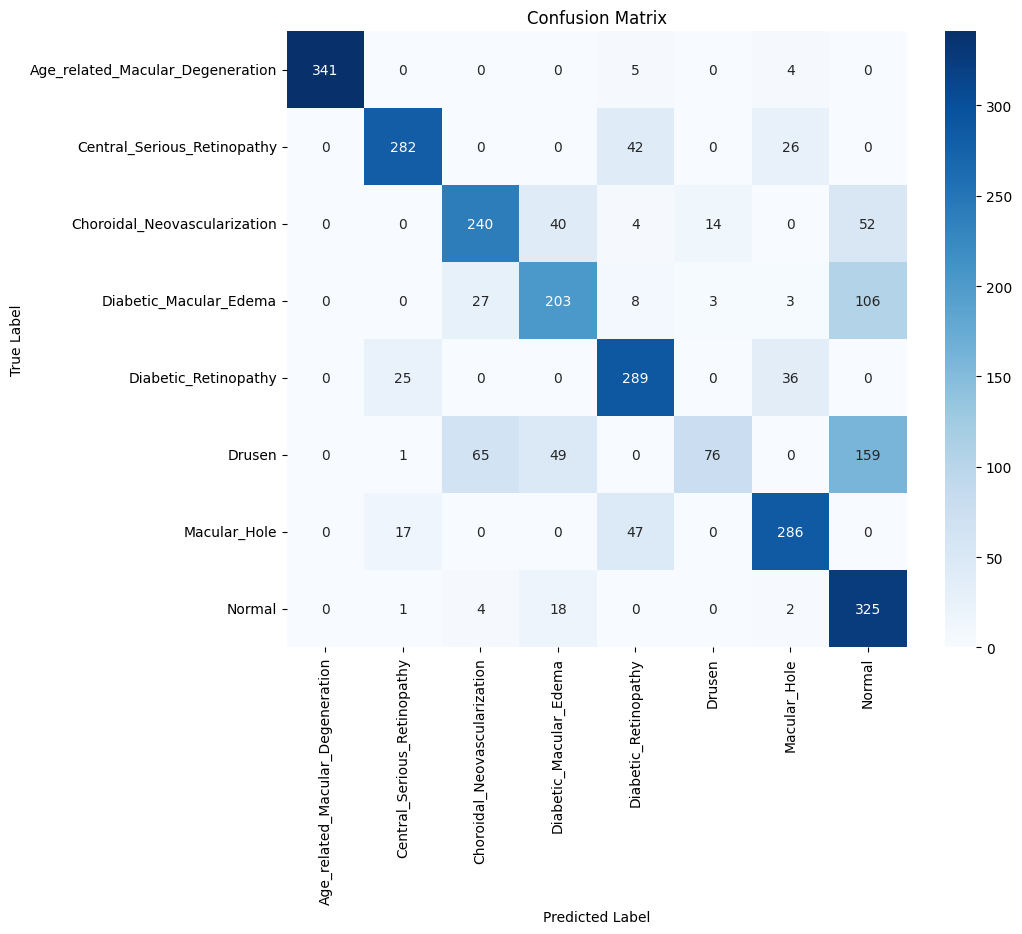


Model size: 42.65 MB
Total parameters: 11,180,616


In [80]:
evaluate_model(model_res_aug, test_loader)

print(f"\nModel size: {model_size_mb(model_res_aug):.2f} MB")
print(f"Total parameters: {sum(p.numel() for p in model_res_aug.parameters()):,}")


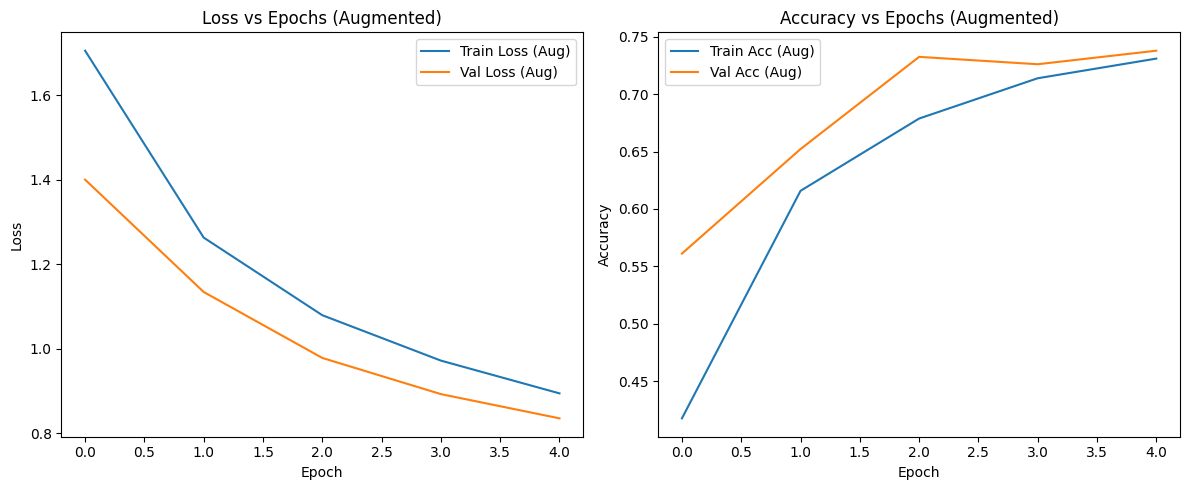

In [81]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_res_aug, label="Train Loss (Aug)")
plt.plot(val_loss_res_aug, label="Val Loss (Aug)")
plt.title("Loss vs Epochs (Augmented)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_res_aug, label="Train Acc (Aug)")
plt.plot(val_acc_res_aug, label="Val Acc (Aug)")
plt.title("Accuracy vs Epochs (Augmented)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


# VGG16- M Shamimul Haque Mondal Shimul 2122085642

In [19]:
from torchvision.models import vgg16

model_vgg = vgg16(weights='VGG16_Weights.IMAGENET1K_V1')

# Freeze all layers
for param in model_vgg.parameters():
    param.requires_grad = False

# Replace final classifier layer
in_features = model_vgg.classifier[6].in_features
model_vgg.classifier[6] = nn.Linear(in_features, len(class_names))

model_vgg = model_vgg.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_vgg = optim.Adam(model_vgg.parameters(), lr=1e-4)

In [6]:
from tqdm import tqdm
import time

def train_model_vgg(model, criterion, optimizer, train_loader, val_loader, num_epochs=5):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    since = time.time()

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss, running_corrects = 0.0, 0
        total_samples = 0

        loop = tqdm(train_loader, desc="Training", leave=True)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_size = inputs.size(0)
            total_samples += batch_size
            running_loss += loss.item() * batch_size
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels).item()

            current_loss = running_loss / total_samples
            current_acc = running_corrects / total_samples
            loop.set_postfix(loss=f"{current_loss:.4f}", acc=f"{current_acc:.4f}")

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        # Validation
        model.eval()
        val_running_loss, val_running_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels).item()

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects / len(val_loader.dataset)
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        print(f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
        print(f"Val   Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.4f}")

    total_time = time.time() - since
    print(f"\nTraining completed in {total_time:.0f} seconds")
    return train_loss, val_loss, train_acc, val_acc, total_time

In [8]:
train_loss_vgg, val_loss_vgg, train_acc_vgg, val_acc_vgg, training_time_vgg = train_model_vgg(
    model_vgg, criterion, optimizer_vgg,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=5
)


Epoch 1/5


Training: 100%|██████████| 575/575 [07:55<00:00,  1.21it/s, acc=0.6166, loss=1.2580]


Train Loss: 1.2580, Acc: 0.6166
Val   Loss: 0.9209, Acc: 0.7239

Epoch 2/5


Training: 100%|██████████| 575/575 [07:52<00:00,  1.22it/s, acc=0.7217, loss=0.8568]


Train Loss: 0.8568, Acc: 0.7217
Val   Loss: 0.7485, Acc: 0.7554

Epoch 3/5


Training: 100%|██████████| 575/575 [07:28<00:00,  1.28it/s, acc=0.7471, loss=0.7500]


Train Loss: 0.7500, Acc: 0.7471
Val   Loss: 0.6693, Acc: 0.7746

Epoch 4/5


Training: 100%|██████████| 575/575 [07:05<00:00,  1.35it/s, acc=0.7590, loss=0.6902]


Train Loss: 0.6902, Acc: 0.7590
Val   Loss: 0.6232, Acc: 0.7911

Epoch 5/5


Training: 100%|██████████| 575/575 [06:58<00:00,  1.37it/s, acc=0.7673, loss=0.6575]


Train Loss: 0.6575, Acc: 0.7673
Val   Loss: 0.5893, Acc: 0.7989

Training completed in 2583 seconds


### That below model loading cell is optional. You can ignore it. Don't run thie cell = preferable

In [9]:
# Define a filename for saving the VGG16 model
model_save_path = "VGG16_basic.pth"

# Save the entire model state
torch.save({
    'model_state_dict': model_vgg.state_dict(),
    'optimizer_state_dict': optimizer_vgg.state_dict(),
    'train_loss': train_loss_vgg,
    'val_loss': val_loss_vgg,
    'train_acc': train_acc_vgg,
    'val_acc': val_acc_vgg,
    'training_time': training_time_vgg,
    'num_classes': len(class_names),
    'class_names': class_names,
    'batch_size': batch_size
}, model_save_path)

print(f"\nVGG16 Model saved to {model_save_path}")


VGG16 Model saved to VGG16_basic.pth


Classification Report:

                                  precision    recall  f1-score   support

Age_related_Macular_Degeneration       0.98      0.99      0.99       350
     Central_Serious_Retinopathy       0.86      0.93      0.89       350
    Choroidal_Neovascularization       0.75      0.70      0.72       350
          Diabetic_Macular_Edema       0.80      0.68      0.74       350
            Diabetic_Retinopathy       0.84      0.81      0.83       350
                          Drusen       0.70      0.60      0.65       350
                    Macular_Hole       0.88      0.84      0.86       350
                          Normal       0.68      0.91      0.78       350

                        accuracy                           0.81      2800
                       macro avg       0.81      0.81      0.81      2800
                    weighted avg       0.81      0.81      0.81      2800


Total Accuracy:  0.8086
Total Precision: 0.8113
Total Recall:    0.8086
Total F1 Sco

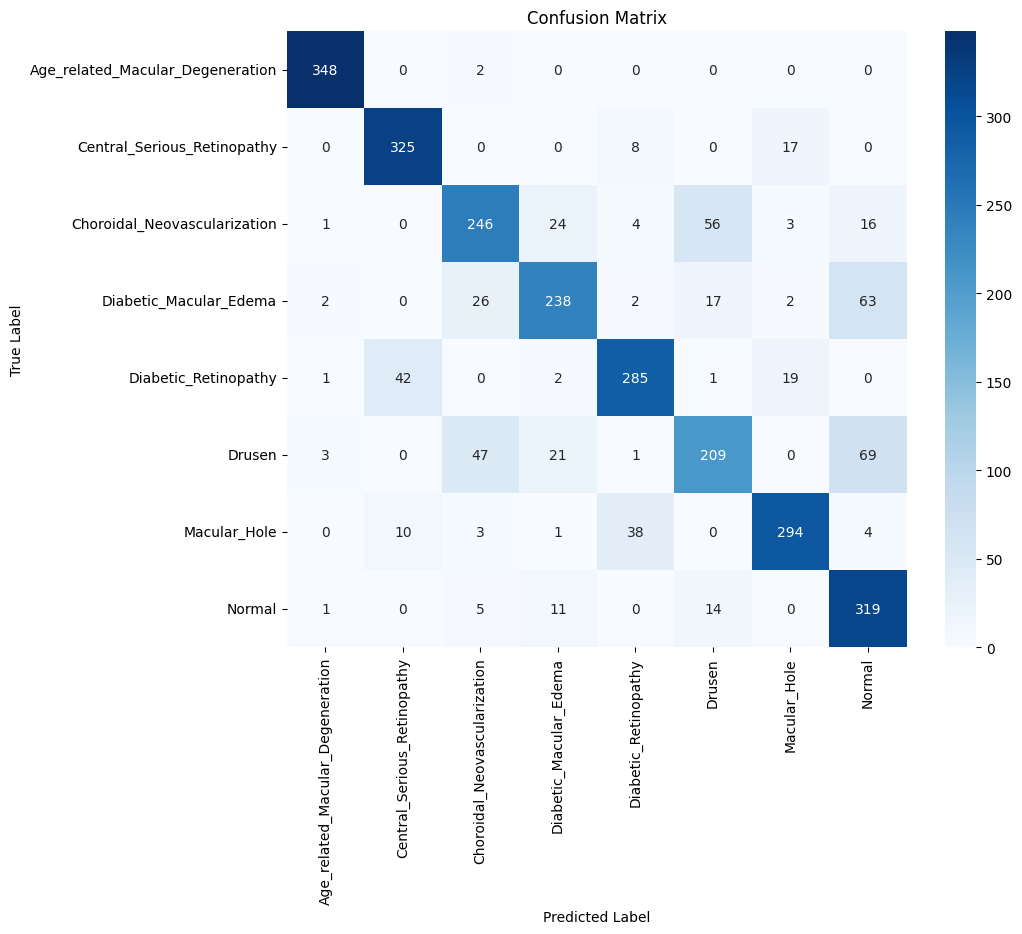

Model size: 512.29 MB
Total parameters: 134,293,320


In [10]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import torch

def evaluate_model(model, dataloader):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.numpy())

    # Classification Report
    report = classification_report(targets, preds, target_names=class_names, output_dict=True)
    print("Classification Report:\n")
    print(classification_report(targets, preds, target_names=class_names))

    # Precision, Recall, F1 (weighted average)
    precision, recall, f1, _ = precision_recall_fscore_support(targets, preds, average='weighted')
    accuracy = accuracy_score(targets, preds)
    print(f"\nTotal Accuracy:  {accuracy:.4f}")
    print(f"Total Precision: {precision:.4f}")
    print(f"Total Recall:    {recall:.4f}")
    print(f"Total F1 Score:  {f1:.4f}")

    # Accuracy
    

    # Confusion Matrix
    cm = confusion_matrix(targets, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Run Evaluation
evaluate_model(model_vgg, test_loader)

# Model size and parameter count
def model_size_mb(model):
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    return param_size / 1024**2  # MB

print(f"Model size: {model_size_mb(model_vgg):.2f} MB")
print(f"Total parameters: {sum(p.numel() for p in model_vgg.parameters()):,}")

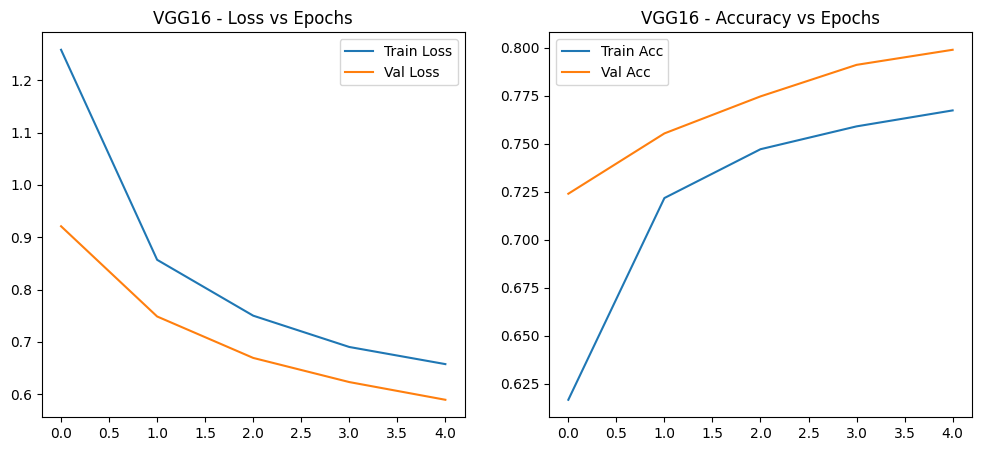

In [11]:
# Plot training curves for VGG16
epochs = len(train_loss_vgg)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_loss_vgg, label="Train Loss")
plt.plot(range(epochs), val_loss_vgg, label="Val Loss")
plt.title("VGG16 - Loss vs Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_acc_vgg, label="Train Acc")
plt.plot(range(epochs), val_acc_vgg, label="Val Acc")
plt.title("VGG16 - Accuracy vs Epochs")
plt.legend()

plt.show()

In [13]:
augmented_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Apply augmentation to train set only
train_ds_aug = datasets.ImageFolder(train_dir, transform=augmented_transform)
train_loader_aug = DataLoader(train_ds_aug, batch_size=batch_size, shuffle=True)

In [14]:
# VGG16 with augmented data
model_vgg_aug = vgg16(weights='VGG16_Weights.IMAGENET1K_V1')
for param in model_vgg_aug.parameters():
    param.requires_grad = False

# Replace final classifier layer
in_features = model_vgg_aug.classifier[6].in_features
model_vgg_aug.classifier[6] = nn.Linear(in_features, len(class_names))
model_vgg_aug = model_vgg_aug.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_vgg_aug = optim.Adam(model_vgg_aug.parameters(), lr=1e-4)

In [15]:
# Train VGG16 with augmented data
train_loss_vgg_aug, val_loss_vgg_aug, train_acc_vgg_aug, val_acc_vgg_aug, time_vgg_aug = train_model_vgg(
    model_vgg_aug, criterion, optimizer_vgg_aug,
    train_loader=train_loader_aug,
    val_loader=val_loader,
    num_epochs=5
)


Epoch 1/5


Training: 100%|██████████| 575/575 [10:13<00:00,  1.07s/it, acc=0.5400, loss=1.4459]


Train Loss: 1.4459, Acc: 0.5400
Val   Loss: 1.0417, Acc: 0.6707

Epoch 2/5


Training: 100%|██████████| 575/575 [09:55<00:00,  1.04s/it, acc=0.6637, loss=1.0261]


Train Loss: 1.0261, Acc: 0.6637
Val   Loss: 0.8618, Acc: 0.7014

Epoch 3/5


Training: 100%|██████████| 575/575 [10:17<00:00,  1.07s/it, acc=0.6917, loss=0.9006]


Train Loss: 0.9006, Acc: 0.6917
Val   Loss: 0.7591, Acc: 0.7368

Epoch 4/5


Training: 100%|██████████| 575/575 [10:25<00:00,  1.09s/it, acc=0.7098, loss=0.8436]


Train Loss: 0.8436, Acc: 0.7098
Val   Loss: 0.7139, Acc: 0.7446

Epoch 5/5


Training: 100%|██████████| 575/575 [09:23<00:00,  1.02it/s, acc=0.7125, loss=0.7999]


Train Loss: 0.7999, Acc: 0.7125
Val   Loss: 0.6799, Acc: 0.7568

Training completed in 3349 seconds


### That below model loading cell is optional. You can ignore it. Don't run thie cell = preferable

In [16]:
# Save augmented VGG16 model
model_save_path = "VGG16_aug.pth"

torch.save({
    'model_state_dict': model_vgg_aug.state_dict(),
    'optimizer_state_dict': optimizer_vgg_aug.state_dict(),
    'train_loss': train_loss_vgg_aug,
    'val_loss': val_loss_vgg_aug,
    'train_acc': train_acc_vgg_aug,
    'val_acc': val_acc_vgg_aug,
    'training_time': time_vgg_aug,
    'num_classes': len(class_names),
    'class_names': class_names,
    'batch_size': batch_size
}, model_save_path)

print(f"\nVGG16 Augmented Model saved to {model_save_path}")


VGG16 Augmented Model saved to VGG16_aug.pth


Classification Report:

                                  precision    recall  f1-score   support

Age_related_Macular_Degeneration       0.99      0.96      0.98       350
     Central_Serious_Retinopathy       0.89      0.82      0.85       350
    Choroidal_Neovascularization       0.75      0.65      0.70       350
          Diabetic_Macular_Edema       0.60      0.77      0.68       350
            Diabetic_Retinopathy       0.83      0.81      0.82       350
                          Drusen       0.73      0.43      0.54       350
                    Macular_Hole       0.77      0.84      0.81       350
                          Normal       0.64      0.83      0.72       350

                        accuracy                           0.76      2800
                       macro avg       0.77      0.76      0.76      2800
                    weighted avg       0.77      0.76      0.76      2800


Total Accuracy:  0.7643
Total Precision: 0.7750
Total Recall:    0.7643
Total F1 Sco

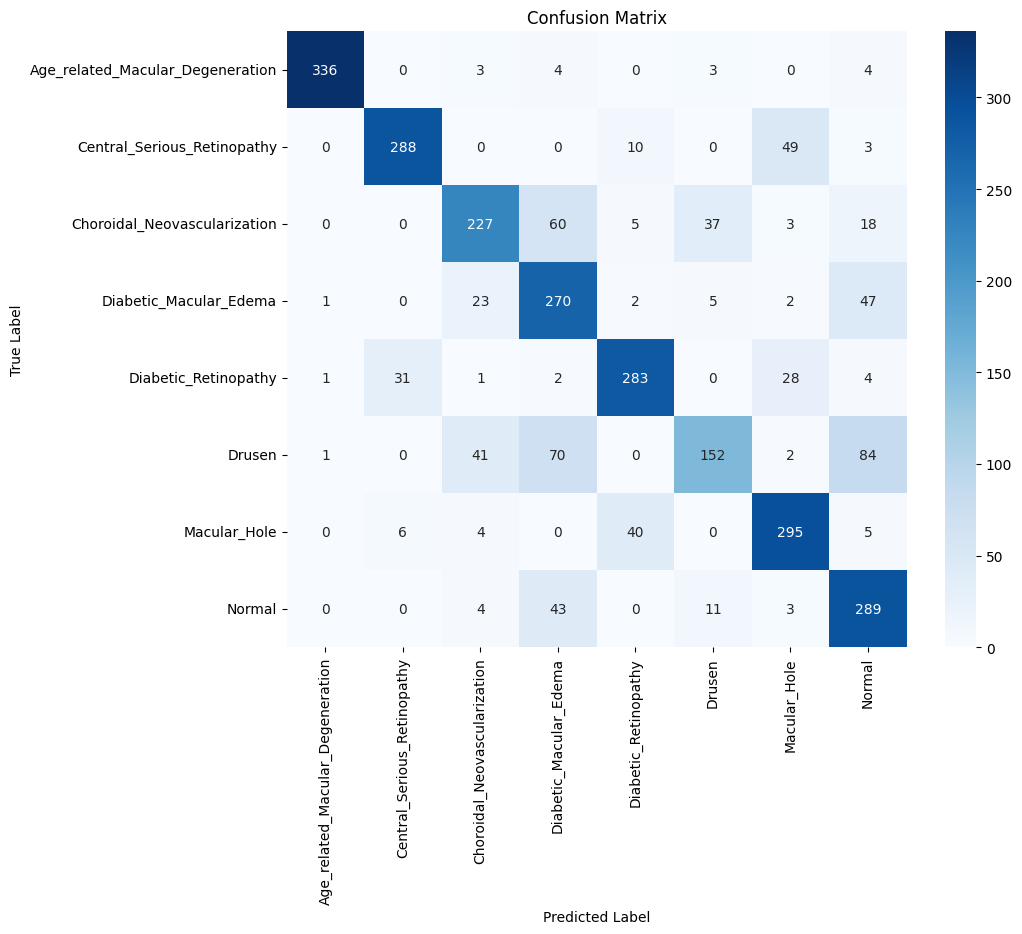


VGG16 Augmented Model size: 512.29 MB
VGG16 Augmented Total parameters: 134,293,320


In [17]:
# Evaluate augmented VGG16 model
evaluate_model(model_vgg_aug, test_loader)

print(f"\nVGG16 Augmented Model size: {model_size_mb(model_vgg_aug):.2f} MB")
print(f"VGG16 Augmented Total parameters: {sum(p.numel() for p in model_vgg_aug.parameters()):,}")

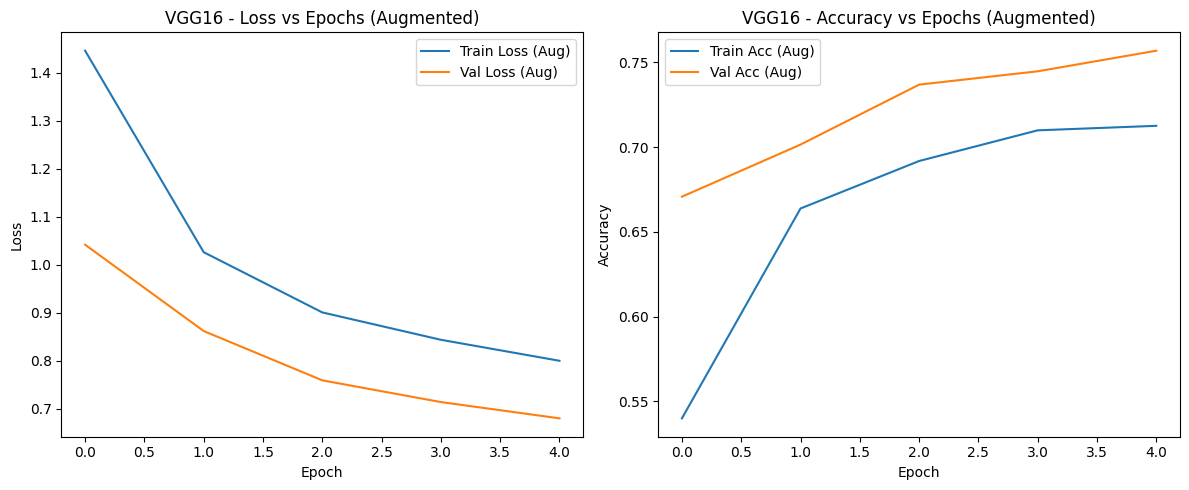

In [18]:
# Plot training curves for augmented VGG16
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_vgg_aug, label="Train Loss (Aug)")
plt.plot(val_loss_vgg_aug, label="Val Loss (Aug)")
plt.title("VGG16 - Loss vs Epochs (Augmented)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_vgg_aug, label="Train Acc (Aug)")
plt.plot(val_acc_vgg_aug, label="Val Acc (Aug)")
plt.title("VGG16 - Accuracy vs Epochs (Augmented)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# ViT

In [63]:
# Change image size for ViT
image_size = 384
batch_size = 32


basic_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [64]:
train_ds = datasets.ImageFolder(train_dir, transform=basic_transform)
val_ds = datasets.ImageFolder(val_dir, transform=basic_transform)
test_ds = datasets.ImageFolder(test_dir, transform=basic_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)

class_names = train_ds.classes
print("Classes:", class_names)

Classes: ['Age_related_Macular_Degeneration', 'Central_Serious_Retinopathy', 'Choroidal_Neovascularization', 'Diabetic_Macular_Edema', 'Diabetic_Retinopathy', 'Drusen', 'Macular_Hole', 'Normal']


In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import vit_b_16, ViT_B_16_Weights
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support


weights = ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1 if hasattr(ViT_B_16_Weights, "IMAGENET1K_SWAG_E2E_V1") else ViT_B_16_Weights.IMAGENET1K_V1
model_vit = vit_b_16(weights=weights)

# Freeze backbone
for param in model_vit.parameters():
    param.requires_grad = False

# Replace classification head
num_classes = len(class_names)
model_vit.heads.head = nn.Linear(model_vit.heads.head.in_features, num_classes)
model_vit = model_vit.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vit.parameters(), lr=1e-4)

In [66]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    since = time.time()

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss, running_corrects, total = 0.0, 0, 0

        loop = tqdm(train_loader, desc="Training", leave=True)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_size = inputs.size(0)
            total += batch_size
            running_loss += loss.item() * batch_size
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels).item()

            loop.set_postfix(loss=f"{running_loss/total:.4f}", acc=f"{running_corrects/total:.4f}")

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        # Validation
        model.eval()
        val_running_loss, val_running_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels).item()

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects / len(val_loader.dataset)
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        print(f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
        print(f"Val   Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.4f}")

    total_time = time.time() - since
    print(f"\nTraining completed in {total_time:.0f} seconds")

    return train_loss, val_loss, train_acc, val_acc, total_time

In [31]:
train_loss, val_loss, train_acc, val_acc, training_time = train_model(
    model_vit, criterion, optimizer, train_loader, val_loader, num_epochs=5
)


Epoch 1/5


Training: 100%|██████████| 575/575 [22:42<00:00,  2.37s/it, acc=0.6943, loss=1.0381]


Train Loss: 1.0381, Acc: 0.6943
Val   Loss: 0.6232, Acc: 0.8214

Epoch 2/5


Training: 100%|██████████| 575/575 [24:19<00:00,  2.54s/it, acc=0.8380, loss=0.5303]


Train Loss: 0.5303, Acc: 0.8380
Val   Loss: 0.4612, Acc: 0.8586

Epoch 3/5


Training: 100%|██████████| 575/575 [26:03<00:00,  2.72s/it, acc=0.8633, loss=0.4258]


Train Loss: 0.4258, Acc: 0.8633
Val   Loss: 0.4003, Acc: 0.8686

Epoch 4/5


Training: 100%|██████████| 575/575 [27:29<00:00,  2.87s/it, acc=0.8783, loss=0.3732]


Train Loss: 0.3732, Acc: 0.8783
Val   Loss: 0.3604, Acc: 0.8757

Epoch 5/5


Training: 100%|██████████| 575/575 [26:59<00:00,  2.82s/it, acc=0.8903, loss=0.3405]


Train Loss: 0.3405, Acc: 0.8903
Val   Loss: 0.3403, Acc: 0.8814

Training completed in 8555 seconds


### That below model loading cell is optional. You can ignore it. Don't run thie cell = preferable

In [33]:
# Define a filename for saving the model
model_save_path = "ViT.pth"

# Save the entire model state (recommended)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss,
    'train_acc': train_acc,
    'val_acc': val_acc,
    'training_time': training_time,
    'num_classes': num_classes,
    'class_names': class_names,
    'batch_size': batch_size
}, model_save_path)

print(f"\nModel saved to {model_save_path}")


Model saved to ViT.pth


Classification Report:

                                  precision    recall  f1-score   support

Age_related_Macular_Degeneration       0.99      1.00      1.00       350
     Central_Serious_Retinopathy       0.97      0.96      0.96       350
    Choroidal_Neovascularization       0.83      0.78      0.81       350
          Diabetic_Macular_Edema       0.78      0.83      0.80       350
            Diabetic_Retinopathy       0.90      0.96      0.93       350
                          Drusen       0.82      0.71      0.76       350
                    Macular_Hole       0.97      0.91      0.94       350
                          Normal       0.78      0.89      0.83       350

                        accuracy                           0.88      2800
                       macro avg       0.88      0.88      0.88      2800
                    weighted avg       0.88      0.88      0.88      2800


Total Accuracy:  0.8789
Total Precision: 0.8805
Total Recall:    0.8789
Total F1 Sco

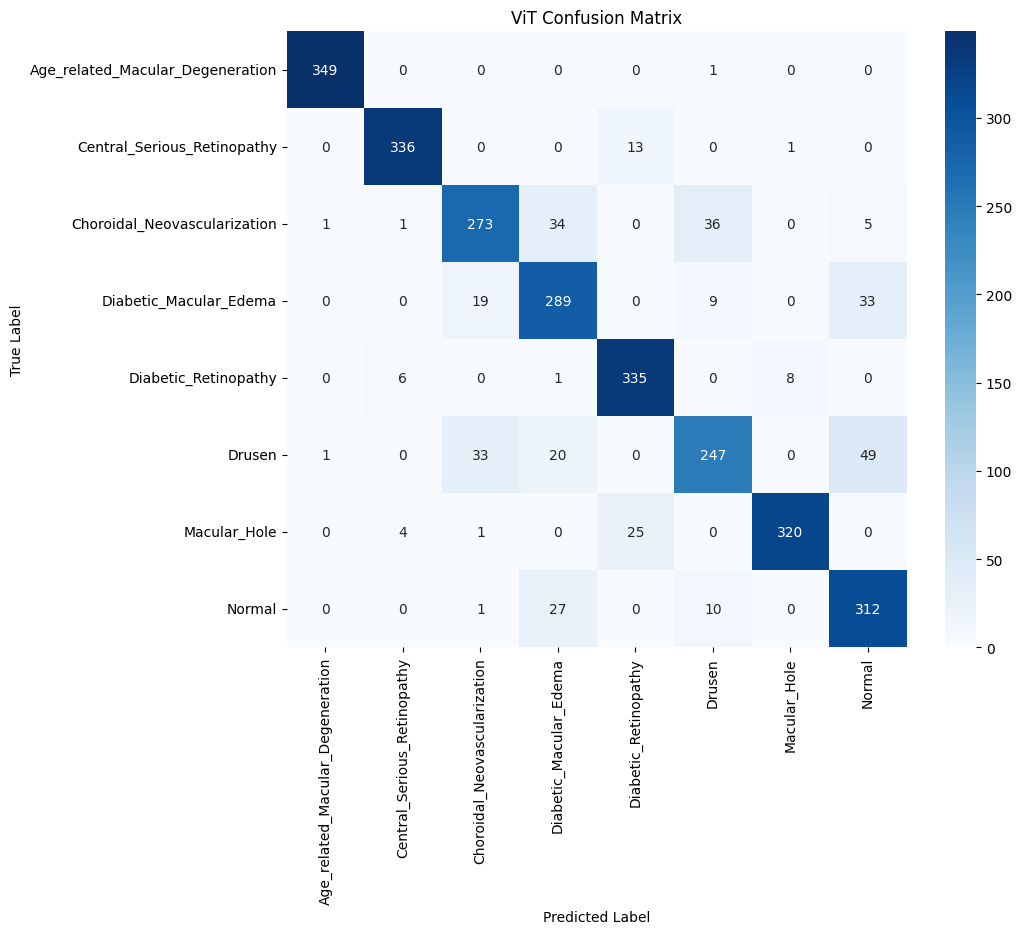

Model size: 328.43 MB
Total parameters: 86,096,648


In [34]:
def evaluate_model(model, dataloader):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.numpy())

    # Accuracy
    acc = (np.array(preds) == np.array(targets)).mean()

    # Classification Report
    print("Classification Report:\n")
    print(classification_report(targets, preds, target_names=class_names))

    # Precision, Recall, F1
    precision, recall, f1, _ = precision_recall_fscore_support(targets, preds, average='weighted')
    print(f"\nTotal Accuracy:  {acc:.4f}")
    print(f"Total Precision: {precision:.4f}")
    print(f"Total Recall:    {recall:.4f}")
    print(f"Total F1 Score:  {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(targets, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("ViT Confusion Matrix")
    plt.show()

    return acc, precision, recall, f1, cm

# Run evaluation
acc, precision, recall, f1, cm = evaluate_model(model_vit, test_loader)

# Model size and parameter count
def model_size_mb(model):
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    return param_size / 1024**2

print(f"Model size: {model_size_mb(model_vit):.2f} MB")
print(f"Total parameters: {sum(p.numel() for p in model_vit.parameters()):,}")


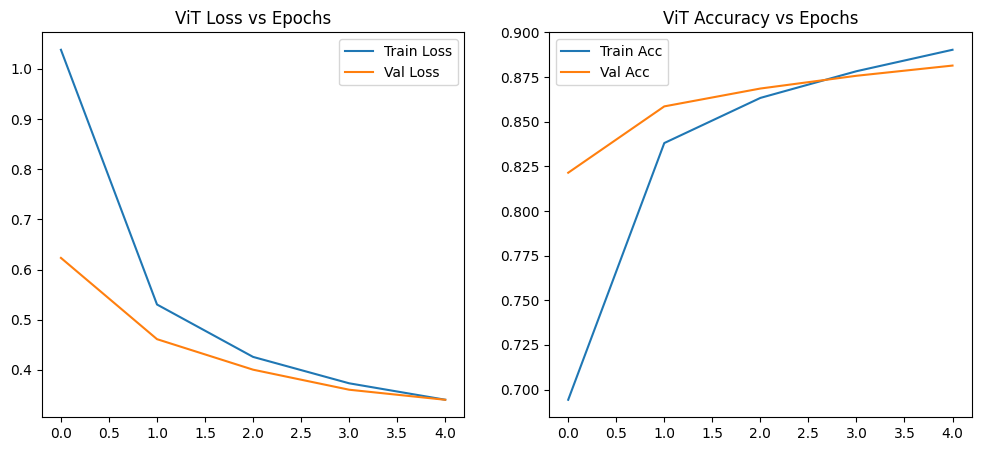

In [35]:
epochs = len(train_loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_loss, label="Train Loss")
plt.plot(range(epochs), val_loss, label="Val Loss")
plt.title("ViT Loss vs Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_acc, label="Train Acc")
plt.plot(range(epochs), val_acc, label="Val Acc")
plt.title("ViT Accuracy vs Epochs")
plt.legend()

plt.show()


In [67]:
augmented_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [68]:
train_ds_aug = datasets.ImageFolder(train_dir, transform=augmented_transform)
train_loader_aug = DataLoader(train_ds_aug, batch_size=batch_size, shuffle=True)



In [69]:
model_vit_aug = vit_b_16(weights=weights)
for param in model_vit_aug.parameters():
    param.requires_grad = False
model_vit_aug.heads.head = nn.Linear(model_vit_aug.heads.head.in_features, num_classes)
model_vit_aug = model_vit_aug.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_aug = optim.Adam(model_vit_aug.parameters(), lr=1e-4)

In [70]:
train_loss_aug, val_loss_aug, train_acc_aug, val_acc_aug, training_time_aug = train_model(
    model_vit_aug, criterion, optimizer_aug, train_loader_aug, val_loader, num_epochs=5
)


Epoch 1/5


Training: 100%|██████████| 575/575 [27:14<00:00,  2.84s/it, acc=0.6763, loss=1.0887]


Train Loss: 1.0887, Acc: 0.6763
Val   Loss: 0.7648, Acc: 0.7696

Epoch 2/5


Training: 100%|██████████| 575/575 [29:46<00:00,  3.11s/it, acc=0.8202, loss=0.5977]


Train Loss: 0.5977, Acc: 0.8202
Val   Loss: 0.5727, Acc: 0.8150

Epoch 3/5


Training: 100%|██████████| 575/575 [29:41<00:00,  3.10s/it, acc=0.8468, loss=0.4853]


Train Loss: 0.4853, Acc: 0.8468
Val   Loss: 0.4871, Acc: 0.8407

Epoch 4/5


Training: 100%|██████████| 575/575 [29:27<00:00,  3.07s/it, acc=0.8608, loss=0.4305]


Train Loss: 0.4305, Acc: 0.8608
Val   Loss: 0.4350, Acc: 0.8586

Epoch 5/5


Training: 100%|██████████| 575/575 [29:14<00:00,  3.05s/it, acc=0.8692, loss=0.3932]


Train Loss: 0.3932, Acc: 0.8692
Val   Loss: 0.4045, Acc: 0.8575

Training completed in 9657 seconds


### That below model loading cell is optional. You can ignore it. Don't run thie cell = preferable

In [75]:
model_save_path = "ViT_aug.pth"

# Save the entire model state (recommended)
torch.save({
    'model_state_dict': model_vit_aug.state_dict(),
    'optimizer_state_dict': optimizer_aug.state_dict(),
    'train_loss': train_loss_aug,
    'val_loss': val_loss_aug,
    'train_acc': train_acc_aug,
    'val_acc': val_acc_aug,
    'training_time': training_time_aug,
    'num_classes': num_classes,
    'class_names': class_names,
    'batch_size': batch_size
}, model_save_path)

print(f"\nModel saved to {model_save_path}")



Model saved to ViT_aug.pth


Classification Report:

                                  precision    recall  f1-score   support

Age_related_Macular_Degeneration       1.00      0.91      0.95       350
     Central_Serious_Retinopathy       0.93      0.98      0.96       350
    Choroidal_Neovascularization       0.74      0.85      0.79       350
          Diabetic_Macular_Edema       0.81      0.77      0.79       350
            Diabetic_Retinopathy       0.91      0.93      0.92       350
                          Drusen       0.85      0.61      0.71       350
                    Macular_Hole       0.97      0.90      0.93       350
                          Normal       0.72      0.91      0.81       350

                        accuracy                           0.86      2800
                       macro avg       0.87      0.86      0.86      2800
                    weighted avg       0.87      0.86      0.86      2800


Total Accuracy:  0.8596
Total Precision: 0.8677
Total Recall:    0.8596
Total F1 Sco

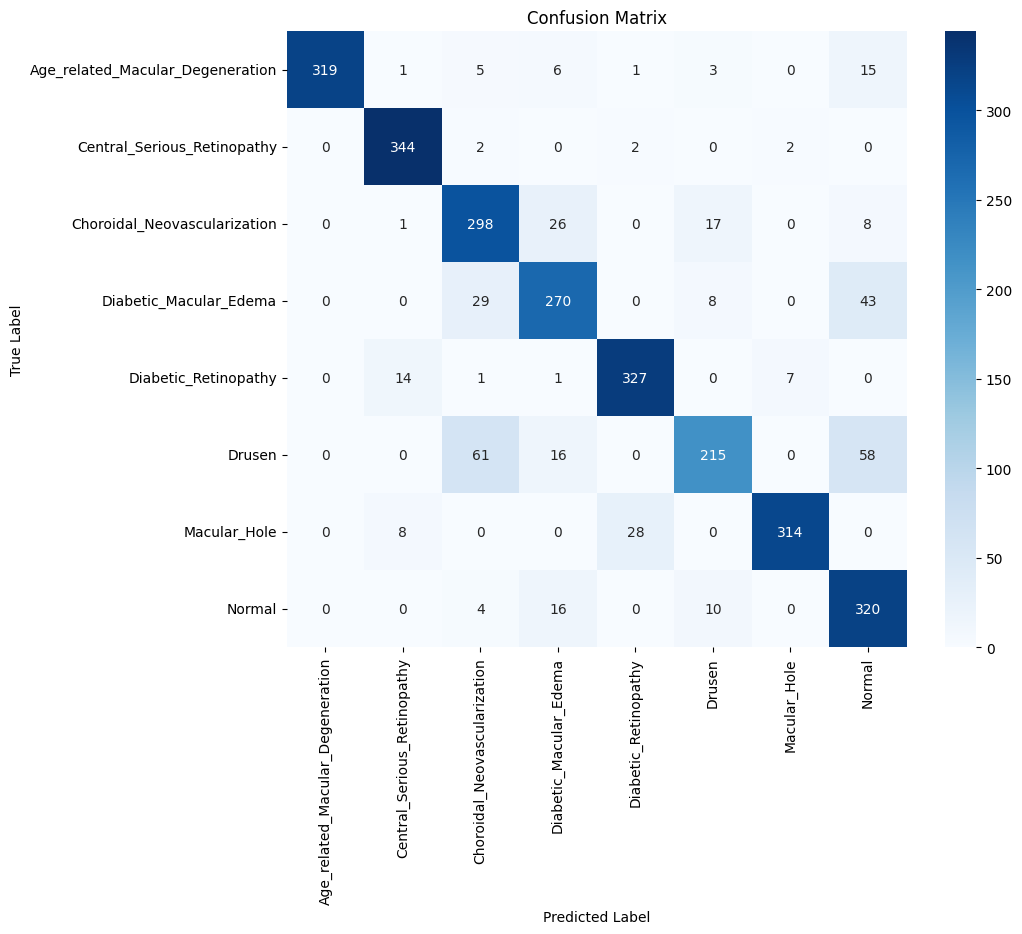

Model size: 328.43 MB
Total parameters: 86,096,648


In [73]:
evaluate_model(model_vit_aug, test_loader)

print(f"Model size: {model_size_mb(model_vit_aug):.2f} MB")
print(f"Total parameters: {sum(p.numel() for p in model_vit_aug.parameters()):,}")


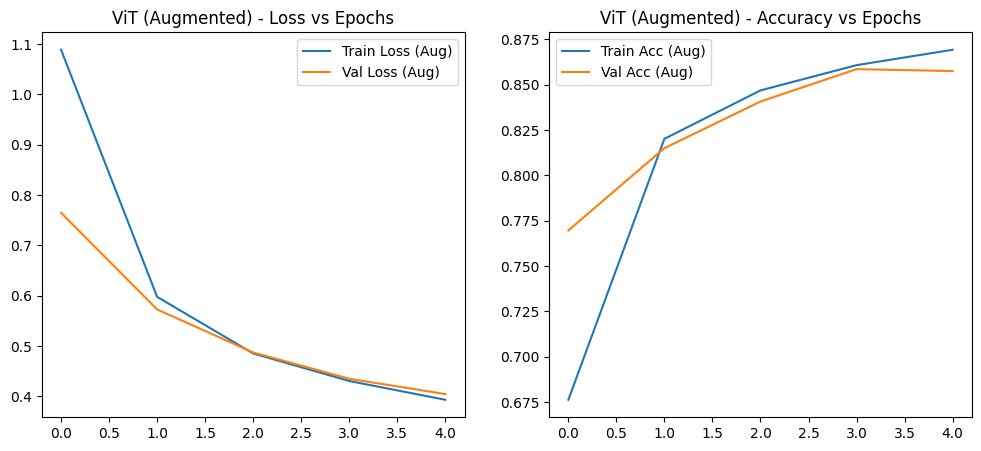

In [74]:
epochs = len(train_loss_aug)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_loss_aug, label="Train Loss (Aug)")
plt.plot(range(epochs), val_loss_aug, label="Val Loss (Aug)")
plt.title("ViT (Augmented) - Loss vs Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_acc_aug, label="Train Acc (Aug)")
plt.plot(range(epochs), val_acc_aug, label="Val Acc (Aug)")
plt.title("ViT (Augmented) - Accuracy vs Epochs")
plt.legend()

plt.show()


# Swin

In [76]:
# Cell 1: Setup
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import swin_t, Swin_T_Weights
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image_size = 384
batch_size = 32

basic_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])



In [77]:
train_ds = datasets.ImageFolder(train_dir, transform=basic_transform)
val_ds   = datasets.ImageFolder(val_dir, transform=basic_transform)
test_ds  = datasets.ImageFolder(test_dir, transform=basic_transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size)
test_loader  = DataLoader(test_ds, batch_size=batch_size)

class_names = train_ds.classes
print("Classes:", class_names)

Classes: ['Age_related_Macular_Degeneration', 'Central_Serious_Retinopathy', 'Choroidal_Neovascularization', 'Diabetic_Macular_Edema', 'Diabetic_Retinopathy', 'Drusen', 'Macular_Hole', 'Normal']


In [80]:
# Cell 2: Model
weights = Swin_T_Weights.IMAGENET1K_V1
model_swin = swin_t(weights=weights)

for param in model_swin.parameters():
    param.requires_grad = False

num_classes = len(class_names)
model_swin.head = nn.Linear(model_swin.head.in_features, num_classes)
model_swin = model_swin.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_swin.parameters(), lr=1e-4)


In [81]:
# Cell 3: Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    since = time.time()

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss, running_corrects, total = 0.0, 0, 0

        loop = tqdm(train_loader, desc="Training", leave=True)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_size = inputs.size(0)
            total += batch_size
            running_loss += loss.item() * batch_size
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels).item()

            loop.set_postfix(loss=f"{running_loss/total:.4f}", acc=f"{running_corrects/total:.4f}")

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc  = running_corrects / len(train_loader.dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        model.eval()
        val_running_loss, val_running_corrects = 0.0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels).item()

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc  = val_running_corrects / len(val_loader.dataset)
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        print(f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
        print(f"Val   Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.4f}")

    total_time = time.time() - since
    print(f"\nTraining completed in {total_time:.0f} seconds")
    return train_loss, val_loss, train_acc, val_acc, total_time


In [83]:
# Cell 4: Train Swin
train_loss, val_loss, train_acc, val_acc, training_time = train_model(
    model_swin, criterion, optimizer, train_loader, val_loader, num_epochs=5
)



Epoch 1/5


Training: 100%|██████████| 575/575 [10:03<00:00,  1.05s/it, acc=0.5786, loss=1.4828]


Train Loss: 1.4828, Acc: 0.5786
Val   Loss: 1.0608, Acc: 0.7429

Epoch 2/5


Training: 100%|██████████| 575/575 [10:29<00:00,  1.09s/it, acc=0.7329, loss=0.9968]


Train Loss: 0.9968, Acc: 0.7329
Val   Loss: 0.8103, Acc: 0.7936

Epoch 3/5


Training: 100%|██████████| 575/575 [09:44<00:00,  1.02s/it, acc=0.7709, loss=0.8204]


Train Loss: 0.8204, Acc: 0.7709
Val   Loss: 0.6900, Acc: 0.8100

Epoch 4/5


Training: 100%|██████████| 575/575 [09:34<00:00,  1.00it/s, acc=0.7884, loss=0.7249]


Train Loss: 0.7249, Acc: 0.7884
Val   Loss: 0.6169, Acc: 0.8221

Epoch 5/5


Training: 100%|██████████| 575/575 [09:04<00:00,  1.06it/s, acc=0.8049, loss=0.6589]


Train Loss: 0.6589, Acc: 0.8049
Val   Loss: 0.5674, Acc: 0.8286

Training completed in 3363 seconds


### That below model loading cell is optional. You can ignore it. Don't run thie cell = preferable

In [85]:
# Define a filename for saving the model
model_save_path = "Swin.pth"

# Save the entire model state (recommended)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss,
    'train_acc': train_acc,
    'val_acc': val_acc,
    'training_time': training_time,
    'num_classes': num_classes,
    'class_names': class_names,
    'batch_size': batch_size
}, model_save_path)

print(f"\nModel saved to {model_save_path}")


Model saved to Swin.pth


Classification Report:

                                  precision    recall  f1-score   support

Age_related_Macular_Degeneration       1.00      1.00      1.00       350
     Central_Serious_Retinopathy       0.82      0.96      0.88       350
    Choroidal_Neovascularization       0.78      0.71      0.74       350
          Diabetic_Macular_Edema       0.78      0.73      0.75       350
            Diabetic_Retinopathy       0.87      0.79      0.83       350
                          Drusen       0.69      0.66      0.67       350
                    Macular_Hole       0.93      0.87      0.90       350
                          Normal       0.73      0.87      0.79       350

                        accuracy                           0.82      2800
                       macro avg       0.83      0.82      0.82      2800
                    weighted avg       0.83      0.82      0.82      2800


Total Accuracy:  0.8229
Total Precision: 0.8251
Total Recall:    0.8229
Total F1 Sco

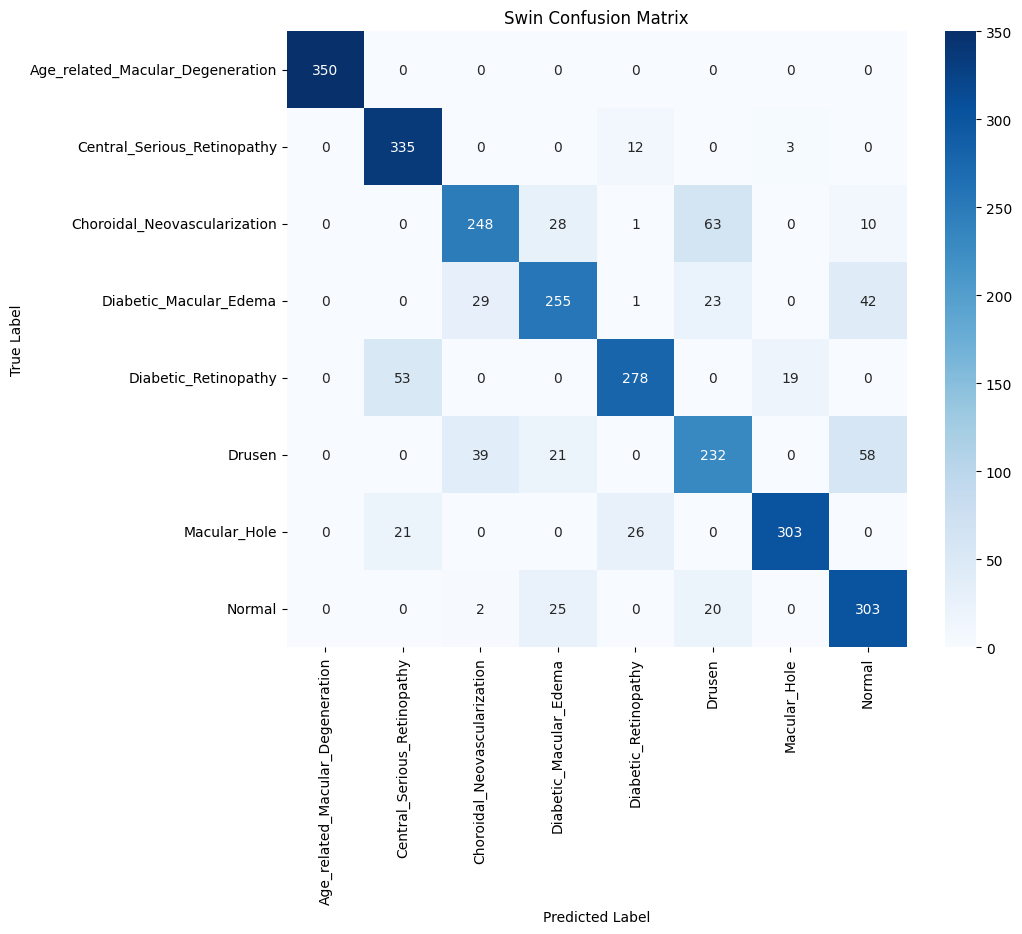

Model size: 105.00 MB
Total parameters: 27,525,506


In [86]:
# Cell 5: Evaluation
def evaluate_model(model, dataloader):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.numpy())

    acc = (np.array(preds) == np.array(targets)).mean()
    print("Classification Report:\n")
    print(classification_report(targets, preds, target_names=class_names))

    precision, recall, f1, _ = precision_recall_fscore_support(targets, preds, average='weighted')
    print(f"\nTotal Accuracy:  {acc:.4f}")
    print(f"Total Precision: {precision:.4f}")
    print(f"Total Recall:    {recall:.4f}")
    print(f"Total F1 Score:  {f1:.4f}")

    cm = confusion_matrix(targets, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Swin Confusion Matrix")
    plt.show()

    return acc, precision, recall, f1, cm

acc, precision, recall, f1, cm = evaluate_model(model_swin, test_loader)


def model_size_mb(model):
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    return param_size / 1024**2

print(f"Model size: {model_size_mb(model_swin):.2f} MB")
print(f"Total parameters: {sum(p.numel() for p in model_swin.parameters()):,}")



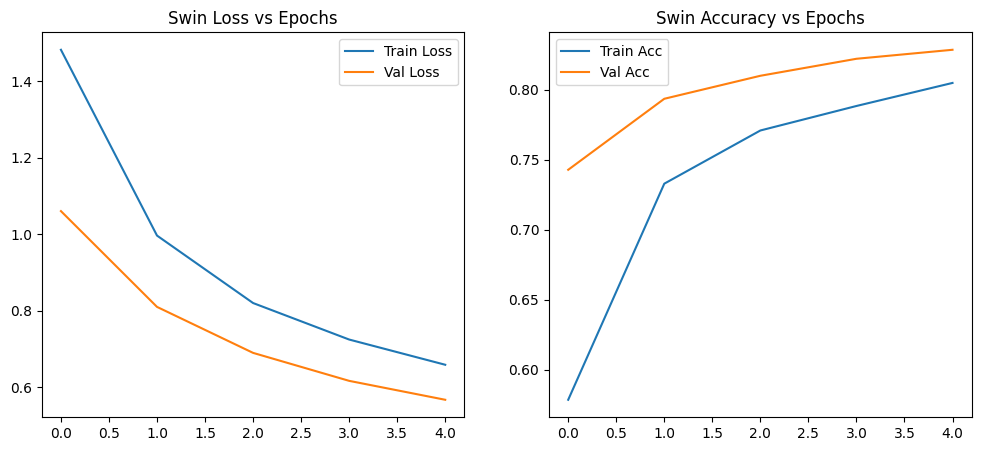

In [87]:
# Cell 7: Plot curves
epochs = len(train_loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_loss, label="Train Loss")
plt.plot(range(epochs), val_loss, label="Val Loss")
plt.title("Swin Loss vs Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_acc, label="Train Acc")
plt.plot(range(epochs), val_acc, label="Val Acc")
plt.title("Swin Accuracy vs Epochs")
plt.legend()

plt.show()


In [88]:
augmented_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_ds_aug = datasets.ImageFolder(train_dir, transform=augmented_transform)
train_loader_aug = DataLoader(train_ds_aug, batch_size=batch_size, shuffle=True)

In [89]:
model_swin_aug = swin_t(weights=weights)
for param in model_swin_aug.parameters():
    param.requires_grad = False
model_swin_aug.head = nn.Linear(model_swin_aug.head.in_features, num_classes)
model_swin_aug = model_swin_aug.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_aug = optim.Adam(model_swin_aug.parameters(), lr=1e-4)

In [90]:
train_loss_aug, val_loss_aug, train_acc_aug, val_acc_aug, training_time_aug = train_model(
    model_swin_aug, criterion, optimizer_aug, train_loader_aug, val_loader, num_epochs=5
)


Epoch 1/5


Training: 100%|██████████| 575/575 [14:20<00:00,  1.50s/it, acc=0.5587, loss=1.5999]


Train Loss: 1.5999, Acc: 0.5587
Val   Loss: 1.1307, Acc: 0.7129

Epoch 2/5


Training: 100%|██████████| 575/575 [13:31<00:00,  1.41s/it, acc=0.7254, loss=1.1096]


Train Loss: 1.1096, Acc: 0.7254
Val   Loss: 0.8683, Acc: 0.7396

Epoch 3/5


Training: 100%|██████████| 575/575 [13:49<00:00,  1.44s/it, acc=0.7519, loss=0.9157]


Train Loss: 0.9157, Acc: 0.7519
Val   Loss: 0.7342, Acc: 0.7893

Epoch 4/5


Training: 100%|██████████| 575/575 [13:16<00:00,  1.39s/it, acc=0.7700, loss=0.8147]


Train Loss: 0.8147, Acc: 0.7700
Val   Loss: 0.6673, Acc: 0.7864

Epoch 5/5


Training: 100%|██████████| 575/575 [14:30<00:00,  1.51s/it, acc=0.7852, loss=0.7378]


Train Loss: 0.7378, Acc: 0.7852
Val   Loss: 0.6153, Acc: 0.8007

Training completed in 4623 seconds


### That below model loading cell is optional. You can ignore it. Don't run thie cell = preferable

In [96]:
# Save augmented VGG16 model
model_save_path = "Swin_aug.pth"

torch.save({
    'model_state_dict': model_swin_aug.state_dict(),
    'optimizer_state_dict': optimizer_aug.state_dict(),
    'train_loss': train_loss_aug,
    'val_loss': val_loss_aug,
    'train_acc': train_acc_aug,
    'val_acc': val_acc_aug,
    'training_time': training_time_aug,
    'num_classes': len(class_names),
    'class_names': class_names,
    'batch_size': batch_size
}, model_save_path)

print(f"\nSwin_aug Augmented Model saved to {model_save_path}")


Swin_aug Augmented Model saved to Swin_aug.pth


Classification Report:

                                  precision    recall  f1-score   support

Age_related_Macular_Degeneration       1.00      1.00      1.00       350
     Central_Serious_Retinopathy       0.84      0.91      0.87       350
    Choroidal_Neovascularization       0.72      0.74      0.73       350
          Diabetic_Macular_Edema       0.88      0.57      0.69       350
            Diabetic_Retinopathy       0.83      0.82      0.83       350
                          Drusen       0.71      0.53      0.60       350
                    Macular_Hole       0.88      0.87      0.87       350
                          Normal       0.62      0.95      0.75       350

                        accuracy                           0.80      2800
                       macro avg       0.81      0.80      0.79      2800
                    weighted avg       0.81      0.80      0.79      2800


Total Accuracy:  0.7979
Total Precision: 0.8103
Total Recall:    0.7979
Total F1 Sco

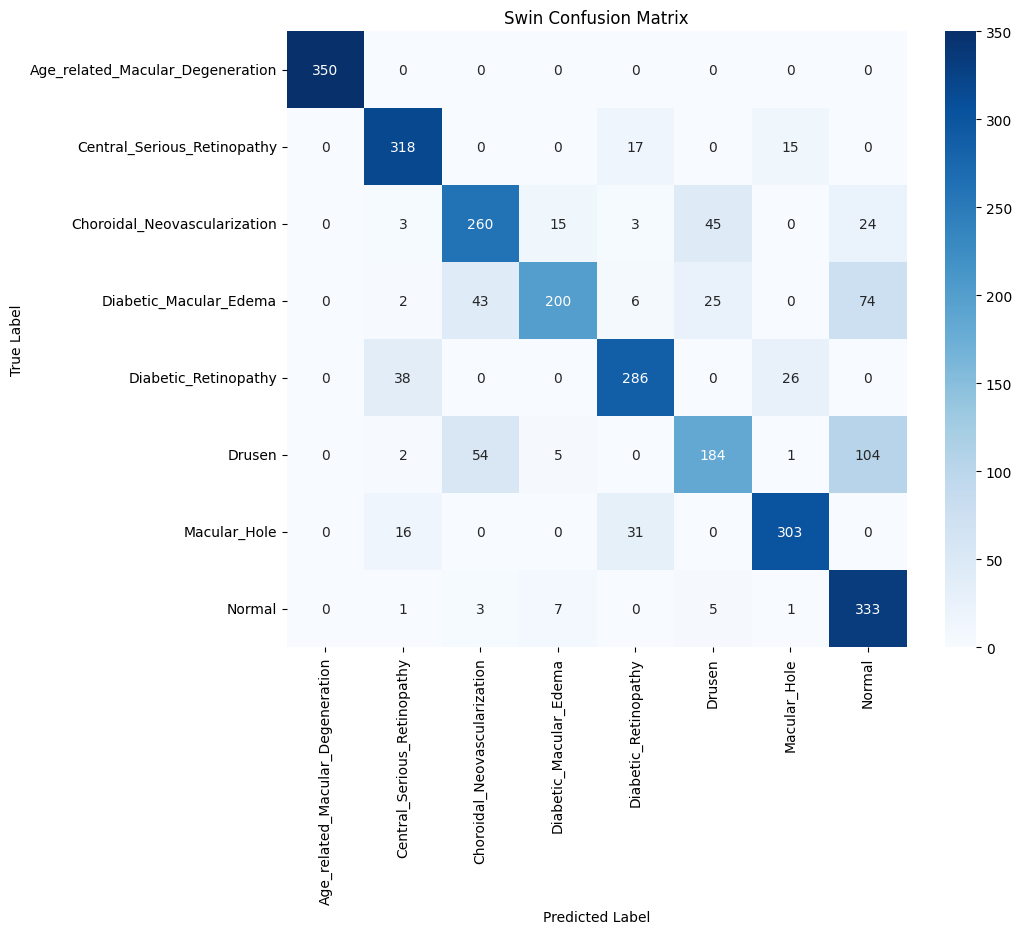

Model size: 105.00 MB
Total parameters: 27,525,506


In [91]:
evaluate_model(model_swin_aug, test_loader)

print(f"Model size: {model_size_mb(model_swin_aug):.2f} MB")
print(f"Total parameters: {sum(p.numel() for p in model_swin_aug.parameters()):,}")

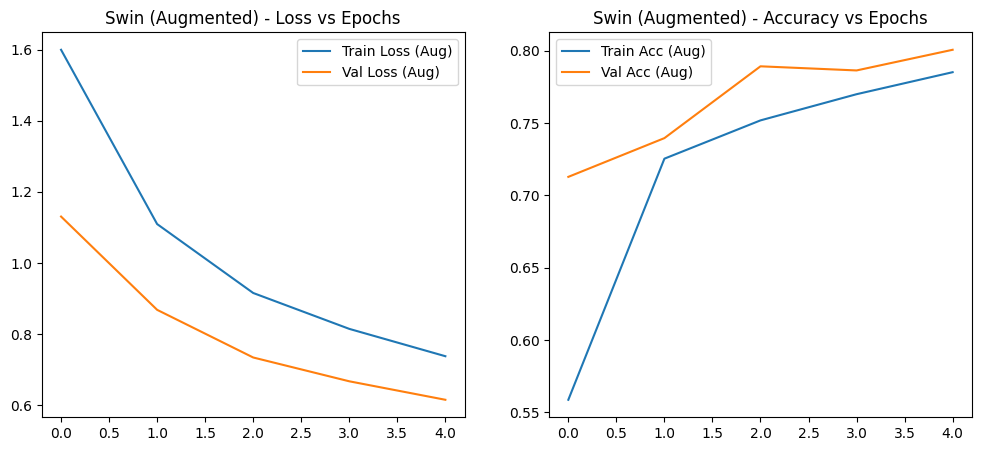

In [92]:
epochs = len(train_loss_aug)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_loss_aug, label="Train Loss (Aug)")
plt.plot(range(epochs), val_loss_aug, label="Val Loss (Aug)")
plt.title("Swin (Augmented) - Loss vs Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_acc_aug, label="Train Acc (Aug)")
plt.plot(range(epochs), val_acc_aug, label="Val Acc (Aug)")
plt.title("Swin (Augmented) - Accuracy vs Epochs")
plt.legend()

plt.show()

# Novelty

In [12]:
# --- Option A: 3D-CNN + ViT Hybrid (Simple) ---
import os, time, math, random
from typing import List, Tuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

import torchvision.transforms as T
from torchvision.models import vit_b_16, ViT_B_16_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
num_classes = len(class_names)



Using device: cuda


In [13]:
# ViT transform (224px + ImageNet normalization)
vit_weights = ViT_B_16_Weights.IMAGENET1K_V1
vit_transform = vit_weights.transforms()  # includes resize/crop/normalize for ViT

# Simple grayscale tensor transform for each 3D slice
volume_size = 128   # H=W of 3D volume (keep small for speed)
to_tensor_gray = T.Compose([
    T.Resize((volume_size, volume_size)),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),                         # -> [1, H, W] in 0..1
    T.Normalize([0.5], [0.5])             # keep it simple
])

def make_pseudo_volume(img_pil: Image.Image, depth: int = 4, aug: bool = False) -> torch.Tensor:
    """
    Build a small pseudo-3D volume by stacking simple variants (slices)
    of the same 2D image. Returns tensor of shape [1, D, H, W].
    """
    # Base RGB -> we will generate grayscale slices
    base = img_pil.copy()

    # deterministic slices (keep simple & lightweight)
    slices: List[Image.Image] = []
    # S1: original
    slices.append(base)
    # S2: horizontal flip
    slices.append(base.transpose(Image.FLIP_LEFT_RIGHT))
    # S3: small rotation
    slices.append(base.rotate(10))
    # S4: slightly more contrast
    slices.append(ImageEnhance.Contrast(base).enhance(1.3))

    # If more than 4 requested, repeat cyclically
    if depth > len(slices):
        k = len(slices)
        slices = slices + slices[:(depth - k)]

    # Keep exactly the requested depth
    slices = slices[:depth]

    # Convert each slice to normalized grayscale tensor and stack along depth
    slice_tensors = [to_tensor_gray(s) for s in slices]             # list of [1,H,W]
    vol = torch.stack(slice_tensors, dim=1)                         # [1, D, H, W]
    return vol


In [14]:
class Hybrid3DDataset(Dataset):
    """
    Wraps an existing ImageFolder-like dataset (train_ds/val_ds/test_ds)
    and returns:
       - vit_img:  [3, 224, 224] for ViT
       - volume3d: [1, D,  H,  W] for 3D-CNN
       - label:    int
    """
    def __init__(self, base_ds, depth: int = 4, aug: bool = False):
        self.samples = base_ds.samples  # list of (path, label)
        self.classes = base_ds.classes
        self.depth = depth
        self.aug = aug

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")

        # 2D branch (ViT)
        vit_img = vit_transform(img)  # [3, 224, 224]

        # 3D branch (pseudo volume)
        vol = make_pseudo_volume(img, depth=self.depth, aug=self.aug)  # [1, D, H, W]
        return vit_img, vol, label


In [15]:
# Build hybrid loaders (no extra aug here; novelty is the 3D conversion)
depth_slices = 4   # you can increase to 5–6 if GPU memory allows
train_h = Hybrid3DDataset(train_ds, depth=depth_slices, aug=False)
val_h   = Hybrid3DDataset(val_ds,   depth=depth_slices, aug=False)
test_h  = Hybrid3DDataset(test_ds,  depth=depth_slices, aug=False)

train_loader_h = DataLoader(train_h, batch_size=batch_size, shuffle=True)
val_loader_h   = DataLoader(val_h,   batch_size=batch_size)
test_loader_h  = DataLoader(test_h,  batch_size=batch_size)

len(train_loader_h), len(val_loader_h), len(test_loader_h)


(575, 88, 88)

vit_img: (3, 224, 224) | vol3d: (1, 4, 128, 128) | label: Age_related_Macular_Degeneration


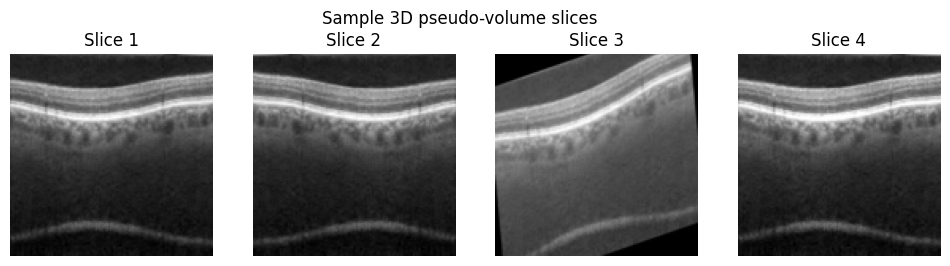

In [18]:
# visualize 3D slices of one sample (first item in train set)
vit_img_sample, vol3d_sample, lab = train_h[0]
print("vit_img:", tuple(vit_img_sample.shape), "| vol3d:", tuple(vol3d_sample.shape), "| label:", class_names[lab])

# Plot depth slices
D = vol3d_sample.shape[1]
plt.figure(figsize=(3*D, 3))
for i in range(D):
    plt.subplot(1, D, i+1)
    # undo simple norm: x*0.5+0.5 to view
    s = vol3d_sample[0, i].cpu().numpy() * 0.5 + 0.5
    plt.imshow(s, cmap="gray")
    plt.title(f"Slice {i+1}")
    plt.axis("off")
plt.suptitle("Sample 3D pseudo-volume slices")
plt.show()


3D volume shape: torch.Size([1, 4, 128, 128])


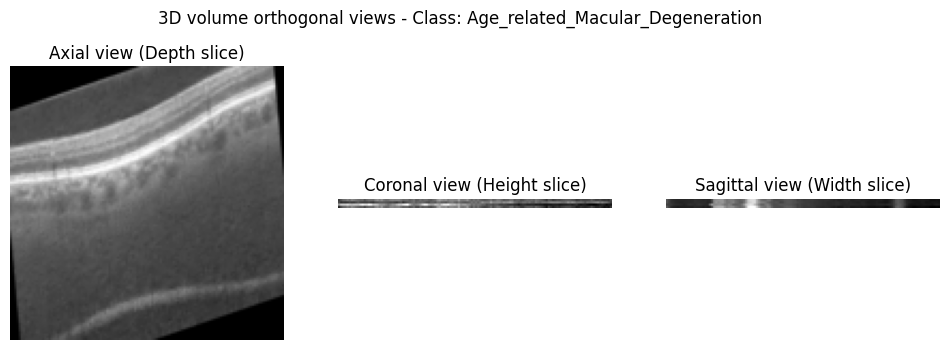

In [19]:
# pick a sample
vit_img_sample, vol3d_sample, lab = train_h[0]
print("3D volume shape:", vol3d_sample.shape)  # [1, D, H, W]

volume = vol3d_sample[0].numpy()  # [D,H,W]

# Get mid-slices in each axis
mid_d = volume.shape[0] // 2
mid_h = volume.shape[1] // 2
mid_w = volume.shape[2] // 2

fig, axs = plt.subplots(1,3, figsize=(12,4))

# Axial (top view) – take middle depth slice
axs[0].imshow(volume[mid_d], cmap="gray")
axs[0].set_title("Axial view (Depth slice)")

# Coronal (front view) – slice across height
axs[1].imshow(volume[:, mid_h, :], cmap="gray")
axs[1].set_title("Coronal view (Height slice)")

# Sagittal (side view) – slice across width
axs[2].imshow(volume[:, :, mid_w], cmap="gray")
axs[2].set_title("Sagittal view (Width slice)")

for ax in axs: ax.axis("off")
plt.suptitle(f"3D volume orthogonal views - Class: {class_names[lab]}")
plt.show()


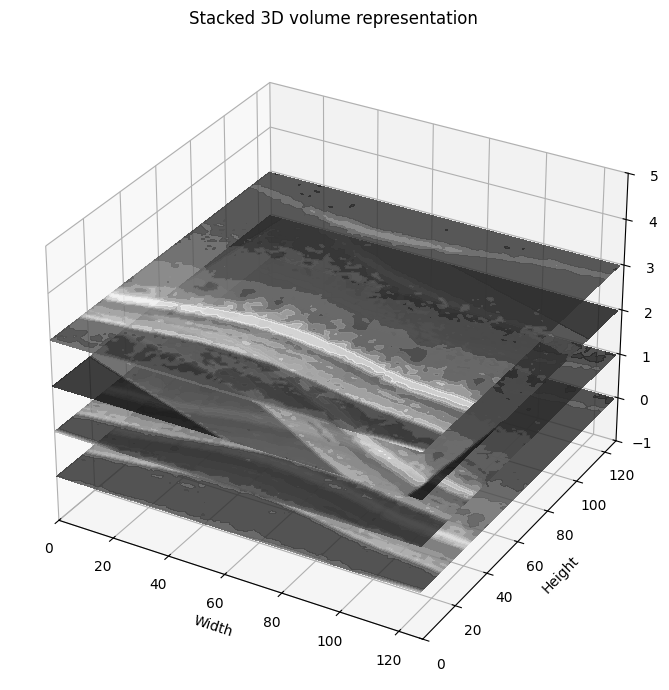

In [20]:
from mpl_toolkits.mplot3d import Axes3D

# take one sample volume
vit_img_sample, vol3d_sample, lab = train_h[0]
volume = vol3d_sample[0].numpy()   # shape: [D,H,W]

D, H, W = volume.shape
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection='3d')

# plot slices stacked along z
spacing = 1.0
for i in range(D):
    ax.contourf(
        np.arange(W), 
        np.arange(H), 
        volume[i], 
        zdir='z', 
        offset=i*spacing, 
        cmap="gray", alpha=0.8
    )

ax.set_xlabel("Width")
ax.set_ylabel("Height")
ax.set_zlabel("Depth")
ax.set_title("Stacked 3D volume representation")

# expand plot limits so nothing is cut off
ax.set_xlim(0, W)
ax.set_ylim(0, H)
ax.set_zlim(-1, D*spacing+1)
plt.tight_layout()
plt.show()


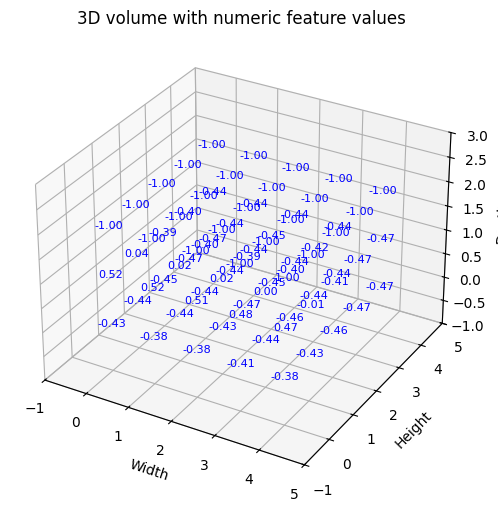

In [21]:
# pick a smaller sub-volume to visualize numeric values
small_vol = volume[:3, :5, :5]   # take only first 3 depth slices, 5x5 area

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

D, H, W = small_vol.shape
for d in range(D):
    for h in range(H):
        for w in range(W):
            val = small_vol[d,h,w]
            ax.text(w, h, d, f"{val:.2f}", color="blue", ha="center", va="center", fontsize=8)

ax.set_xlim(-1, W)
ax.set_ylim(-1, H)
ax.set_zlim(-1, D)
ax.set_xlabel("Width")
ax.set_ylabel("Height")
ax.set_zlabel("Depth")
ax.set_title("3D volume with numeric feature values")
plt.show()


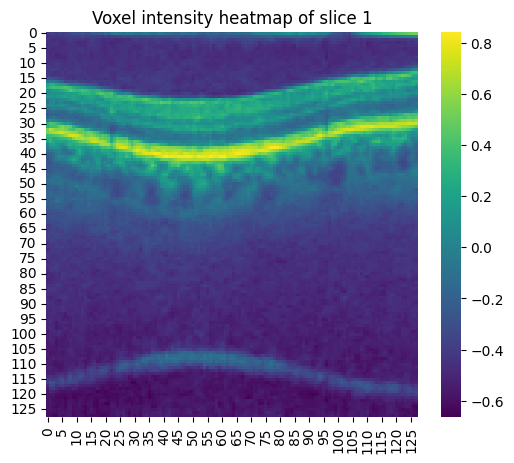

In [22]:
import seaborn as sns


plt.figure(figsize=(6,5))
sns.heatmap(volume[0], cmap="viridis")
plt.title("Voxel intensity heatmap of slice 1")
plt.show()


In [26]:
class Small3DCNN(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(in_ch, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool3d((1,2,2)),          # keep depth, halve H,W

            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool3d((2,2,2)),          # halve D,H,W

            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),

            nn.AdaptiveAvgPool3d((1,1,1))   # -> [B, 64, 1,1,1]
        )

    def forward(self, x):                     # x: [B,1,D,H,W]
        x = self.net(x)
        return x.flatten(1)                   # [B, 64]

class Hybrid3DViT(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        # --- ViT branch (frozen, feature extractor) ---
        self.vit = vit_b_16(weights=vit_weights)
        vit_dim = self.vit.heads.head.in_features  # 768
        for p in self.vit.parameters():
            p.requires_grad = False
        self.vit.heads = nn.Identity()            # vit(x) now returns features (CLS token)

        # --- 3D CNN branch (trainable) ---
        self.cnn3d = Small3DCNN(in_ch=1)
        cnn_dim = 64

        # --- Classifier on concatenated features ---
        self.classifier = nn.Sequential(
            nn.Linear(vit_dim + cnn_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, vit_img, vol3d):
        f2d = self.vit(vit_img)      # [B, 768]
        f3d = self.cnn3d(vol3d)      # [B, 64]
        f   = torch.cat([f2d, f3d], dim=1)
        logits = self.classifier(f)  # [B, C]
        return logits



model = Hybrid3DViT(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()

# Only optimize parameters that require grad (i.e., 3D-CNN + classifier)
optimizer = optim.Adam(
    [p for p in model.parameters() if p.requires_grad],
    lr=1e-4
)


In [27]:
from tqdm import tqdm

# Training function for Hybrid 3D-CNN + ViT
def train_model_hybrid(model, criterion, optimizer, train_loader, val_loader, num_epochs=5):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    since = time.time()

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss, running_corrects, total = 0.0, 0, 0

        loop = tqdm(train_loader, desc="Training", leave=True)
        for vit_x, vol_x, labels in loop:
            vit_x, vol_x, labels = vit_x.to(device), vol_x.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(vit_x, vol_x)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_size = labels.size(0)
            total += batch_size
            running_loss += loss.item() * batch_size
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels).item()

            loop.set_postfix(loss=f"{running_loss/total:.4f}", acc=f"{running_corrects/total:.4f}")

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc  = running_corrects / len(train_loader.dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        # Validation phase
        model.eval()
        val_running_loss, val_running_corrects = 0.0, 0
        with torch.no_grad():
            for vit_x, vol_x, labels in val_loader:
                vit_x, vol_x, labels = vit_x.to(device), vol_x.to(device), labels.to(device)
                outputs = model(vit_x, vol_x)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * labels.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_corrects += torch.sum(preds == labels).item()

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc  = val_running_corrects / len(val_loader.dataset)
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        print(f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
        print(f"Val   Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.4f}")

    total_time = time.time() - since
    print(f"\nTraining completed in {total_time:.0f} seconds")
    return train_loss, val_loss, train_acc, val_acc, total_time


In [29]:
# Train the Hybrid model (with epoch display)
train_loss, val_loss, train_acc, val_acc, training_time = train_model_hybrid(
    model, criterion, optimizer, train_loader_h, val_loader_h, num_epochs=5
)



Epoch 1/5


Training: 100%|██████████| 575/575 [19:38<00:00,  2.05s/it, acc=0.8115, loss=0.6957]


Train Loss: 0.6957, Acc: 0.8115
Val   Loss: 0.3725, Acc: 0.8804

Epoch 2/5


Training: 100%|██████████| 575/575 [18:12<00:00,  1.90s/it, acc=0.8902, loss=0.3330]


Train Loss: 0.3330, Acc: 0.8902
Val   Loss: 0.3174, Acc: 0.8893

Epoch 3/5


Training: 100%|██████████| 575/575 [18:19<00:00,  1.91s/it, acc=0.9073, loss=0.2748]


Train Loss: 0.2748, Acc: 0.9073
Val   Loss: 0.2512, Acc: 0.9164

Epoch 4/5


Training: 100%|██████████| 575/575 [18:26<00:00,  1.93s/it, acc=0.9151, loss=0.2454]


Train Loss: 0.2454, Acc: 0.9151
Val   Loss: 0.2388, Acc: 0.9200

Epoch 5/5


Training: 100%|██████████| 575/575 [18:22<00:00,  1.92s/it, acc=0.9227, loss=0.2244]


Train Loss: 0.2244, Acc: 0.9227
Val   Loss: 0.2147, Acc: 0.9271

Training completed in 6294 seconds


## that below cell must be run/executed to save the model, otherwise won't run.

In [30]:
# Define a filename for saving the model
model_save_path = "hybrid_3dcnn_vit_model.pth"

# Save the entire model state (recommended)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_loss,
    'val_loss': val_loss,
    'train_acc': train_acc,
    'val_acc': val_acc,
    'training_time': training_time,
    'num_classes': num_classes,
    'class_names': class_names,
    'depth_slices': depth_slices,
    'batch_size': batch_size
}, model_save_path)

print(f"\nModel saved to {model_save_path}")


Model saved to hybrid_3dcnn_vit_model.pth


Classification Report:

                                  precision    recall  f1-score   support

Age_related_Macular_Degeneration       1.00      1.00      1.00       350
     Central_Serious_Retinopathy       0.98      1.00      0.99       350
    Choroidal_Neovascularization       0.87      0.81      0.84       350
          Diabetic_Macular_Edema       0.92      0.83      0.87       350
            Diabetic_Retinopathy       0.99      0.96      0.97       350
                          Drusen       0.79      0.81      0.80       350
                    Macular_Hole       0.98      0.99      0.98       350
                          Normal       0.82      0.94      0.88       350

                        accuracy                           0.92      2800
                       macro avg       0.92      0.92      0.92      2800
                    weighted avg       0.92      0.92      0.92      2800


Total Accuracy:  0.9168
Total Precision: 0.9187
Total Recall:    0.9168
Total F1 Sco

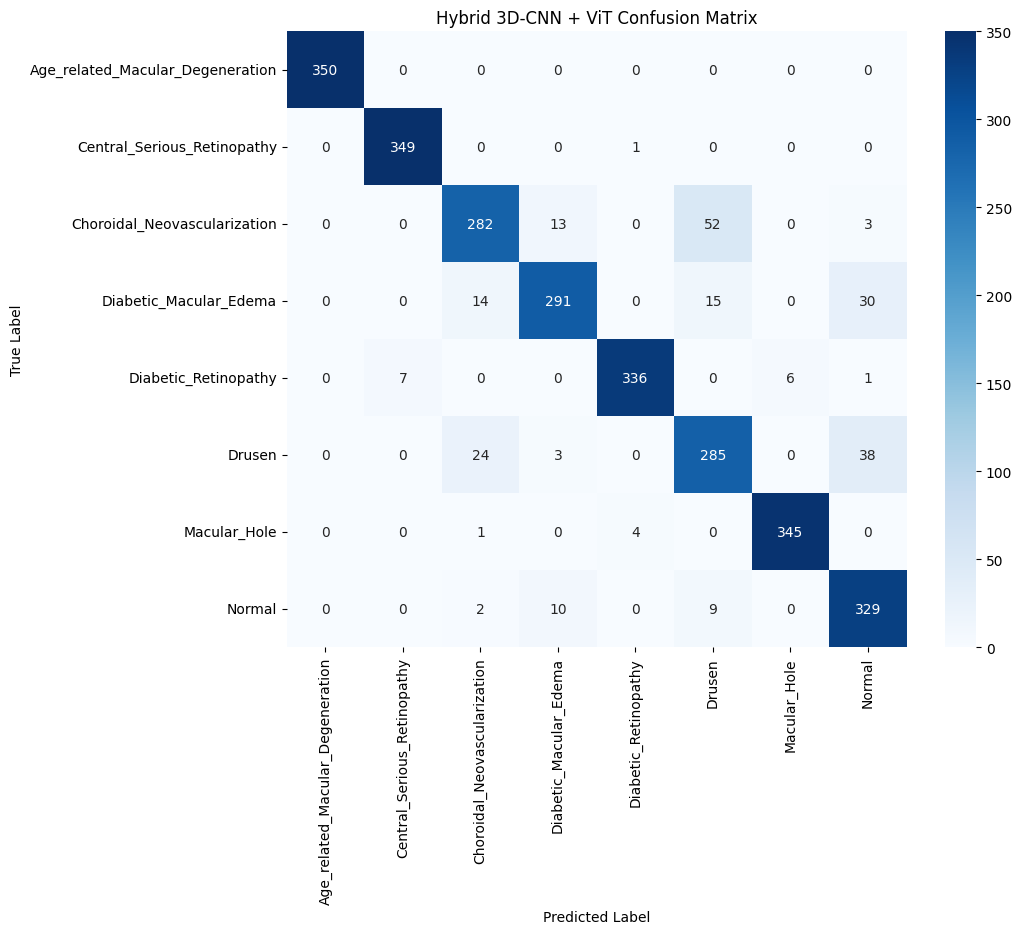

Model size: 328.38 MB
Total parameters: 86,083,848


In [32]:
def evaluate_model(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for vit_img, vol3d, labels in dataloader:  # Unpack both inputs
            vit_img = vit_img.to(device)
            vol3d = vol3d.to(device)
            labels = labels.to(device)
            
            outputs = model(vit_img, vol3d)  # Two inputs!
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    
    acc = (np.array(all_preds) == np.array(all_targets)).mean()
    
    print("Classification Report:\n")
    print(classification_report(all_targets, all_preds, target_names=class_names))

    precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_preds, average='weighted')
    print(f"\nTotal Accuracy:  {acc:.4f}")
    print(f"Total Precision: {precision:.4f}")
    print(f"Total Recall:    {recall:.4f}")
    print(f"Total F1 Score:  {f1:.4f}")

    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Hybrid 3D-CNN + ViT Confusion Matrix")
    plt.show()

    return acc, precision, recall, f1, cm

# Now evaluate your actual hybrid model
acc, precision, recall, f1, cm = evaluate_model(model, test_loader_h, class_names)

def model_size_mb(model):
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    total_size = param_size + buffer_size
    return total_size / 1024**2  # Convert to MB

print(f"Model size: {model_size_mb(model):.2f} MB")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

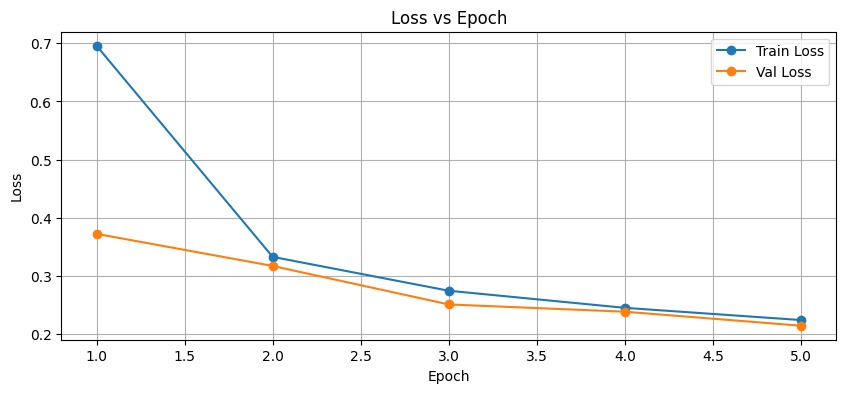

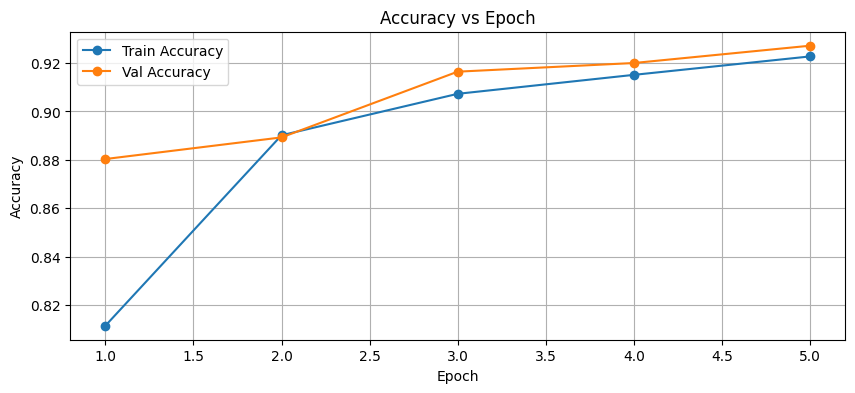

In [11]:
# Load checkpoint
checkpoint = torch.load("hybrid_3dcnn_vit_model.pth", map_location="cpu")

# Extract metrics
train_loss = checkpoint.get("train_loss", [])
val_loss   = checkpoint.get("val_loss", [])
train_acc  = checkpoint.get("train_acc", [])
val_acc    = checkpoint.get("val_acc", [])

epochs = range(1, len(train_loss) + 1)

# --------------------
# Plot Loss
# --------------------
plt.figure(figsize=(10,4))
plt.plot(epochs, train_loss, "o-", label="Train Loss")
plt.plot(epochs, val_loss, "o-", label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.grid(True)
plt.show()

# --------------------
# Plot Accuracy
# --------------------
plt.figure(figsize=(10,4))
plt.plot(epochs, train_acc, "o-", label="Train Accuracy")
plt.plot(epochs, val_acc, "o-", label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.legend()
plt.grid(True)
plt.show()


## cfx

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torchvision.transforms as T
from torchvision.models import vit_b_16, ViT_B_16_Weights

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [16]:
class Small3DCNN(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(in_ch, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool3d((1,2,2)),
            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool3d((2,2,2)),
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool3d((1,1,1))
        )
    def forward(self, x):
        x = self.net(x)
        return x.flatten(1)

class Hybrid3DViT(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        # ViT branch (frozen)
        self.vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        vit_dim = self.vit.heads.head.in_features  # 768
        for p in self.vit.parameters():
            p.requires_grad = False
        self.vit.heads = nn.Identity()
        # 3D CNN branch
        self.cnn3d = Small3DCNN(in_ch=1)
        cnn_dim = 64
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(vit_dim + cnn_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    def forward(self, vit_img, vol3d):
        f2d = self.vit(vit_img)
        f3d = self.cnn3d(vol3d)
        f = torch.cat([f2d, f3d], dim=1)
        return self.classifier(f)

In [17]:
# Path to saved model
model_save_path = "hybrid_3dcnn_vit_model.pth"

# Load checkpoint
checkpoint = torch.load(model_save_path, map_location=device)

# Extract metadata
num_classes = checkpoint['num_classes']
class_names = checkpoint['class_names']
depth_slices = checkpoint['depth_slices']

# Recreate model
model = Hybrid3DViT(num_classes=num_classes).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set to evaluation mode

print(f"Model loaded successfully with {num_classes} classes.")
print(f"Classes: {class_names}")

Model loaded successfully with 8 classes.
Classes: ['Age_related_Macular_Degeneration', 'Central_Serious_Retinopathy', 'Choroidal_Neovascularization', 'Diabetic_Macular_Edema', 'Diabetic_Retinopathy', 'Drusen', 'Macular_Hole', 'Normal']


In [18]:
all_preds = []
all_labels = []

with torch.no_grad():
    for vit_img, vol3d, labels in test_loader_h:
        vit_img = vit_img.to(device)
        vol3d = vol3d.to(device)
        labels = labels.to(device)

        outputs = model(vit_img, vol3d)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Inference completed on test set.")

Inference completed on test set.


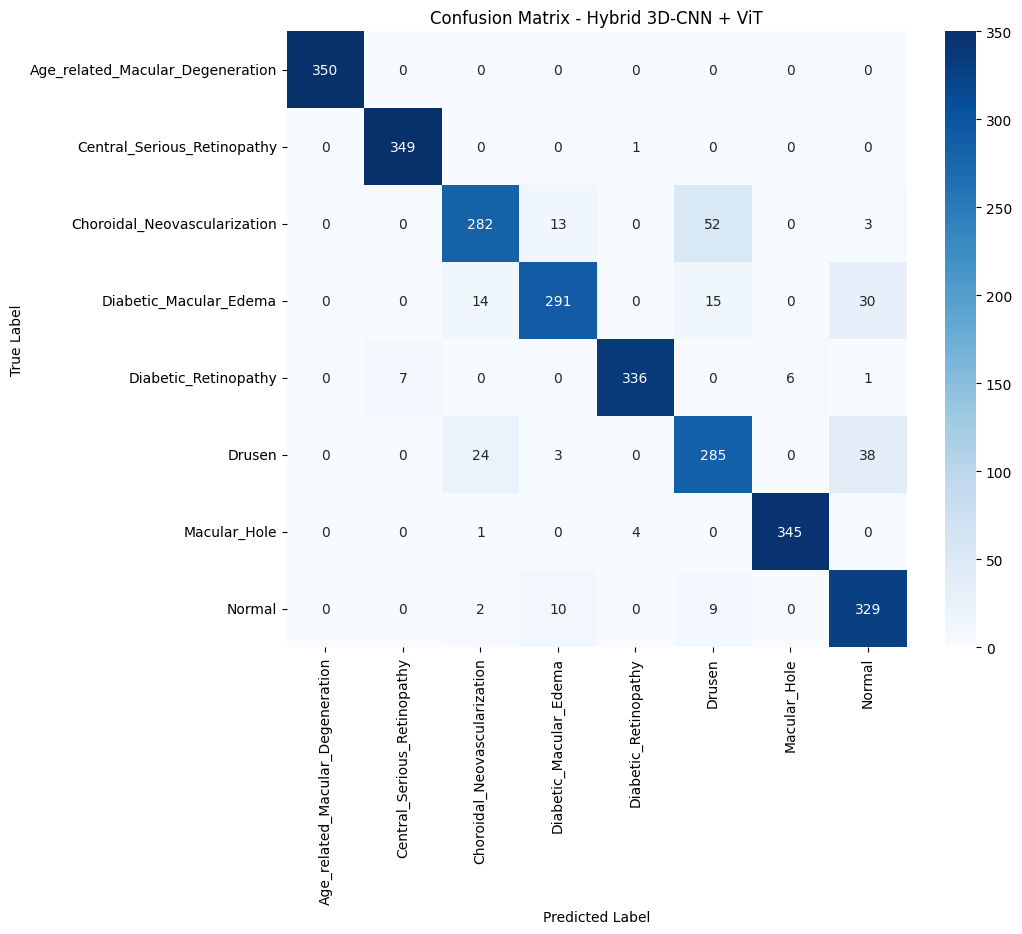

Classification Report:
                                  precision    recall  f1-score   support

Age_related_Macular_Degeneration       1.00      1.00      1.00       350
     Central_Serious_Retinopathy       0.98      1.00      0.99       350
    Choroidal_Neovascularization       0.87      0.81      0.84       350
          Diabetic_Macular_Edema       0.92      0.83      0.87       350
            Diabetic_Retinopathy       0.99      0.96      0.97       350
                          Drusen       0.79      0.81      0.80       350
                    Macular_Hole       0.98      0.99      0.98       350
                          Normal       0.82      0.94      0.88       350

                        accuracy                           0.92      2800
                       macro avg       0.92      0.92      0.92      2800
                    weighted avg       0.92      0.92      0.92      2800



In [19]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Hybrid 3D-CNN + ViT')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Optional: Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

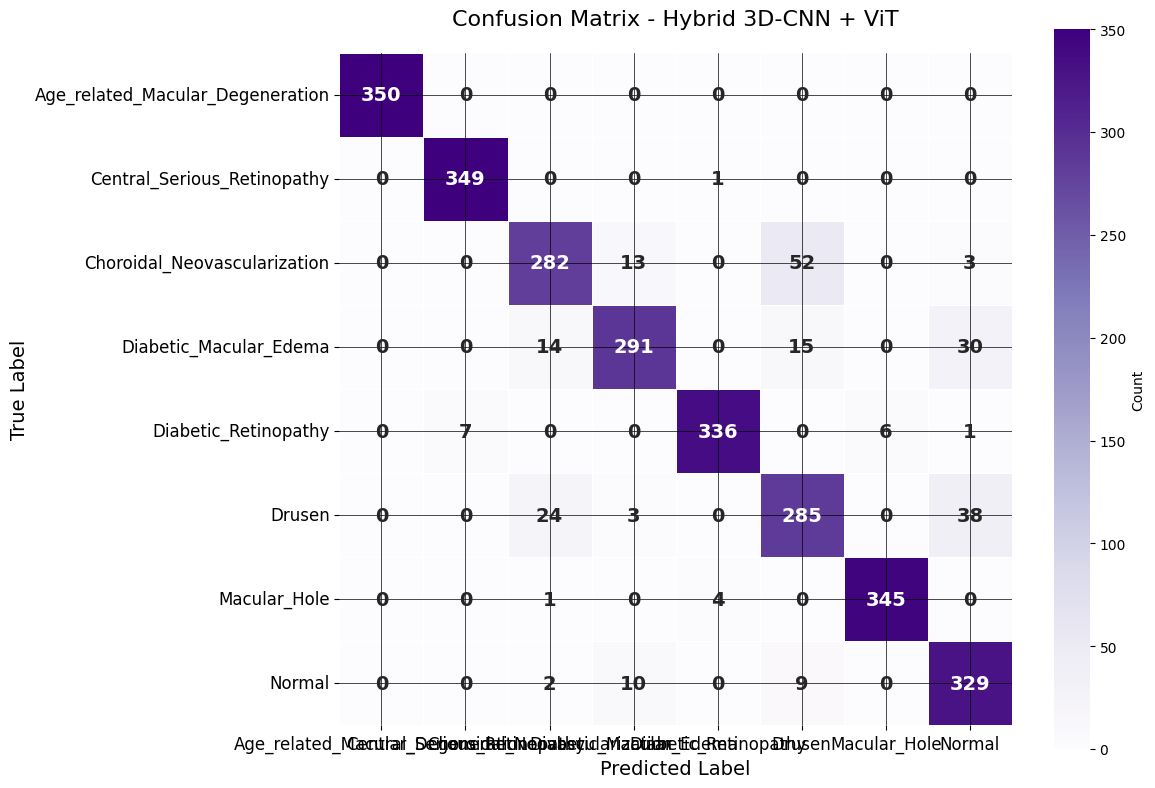

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Set up the plot
plt.figure(figsize=(12, 10))

# Use a custom colormap: dark purple to bright red/orange (like in your image)
cmap = sns.color_palette("Purples", as_cmap=True)  # or "YlOrRd" for warm tones
# Or use this for a more dramatic contrast:
# cmap = sns.color_palette("magma", as_cmap=True)

# Create heatmap with enhanced styling
sns.heatmap(
    cm,
    annot=True,                             # Show numbers
    fmt='d',                                # Format as integers
    cmap=cmap,                              # Custom color map
    cbar=True,                              # Include colorbar
    cbar_kws={'shrink': 0.8, 'label': 'Count'},  # Shrink and label
    square=True,                            # Equal cell sizes
    linewidths=0.5,                         # Add borders
    linecolor='white',                      # White borders for clarity
    annot_kws={"size": 14, "weight": "bold"},  # Bigger, bold numbers
    xticklabels=class_names,
    yticklabels=class_names
)

# Customize labels
plt.title('Confusion Matrix - Hybrid 3D-CNN + ViT', fontsize=16, pad=20)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)

# Make sure tick labels are readable and not rotated
plt.xticks(rotation=0, ha='center', fontsize=12)
plt.yticks(rotation=0, ha='right', fontsize=12)

# Optional: Add grid lines (optional, but improves structure)
for i in range(cm.shape[0] + 1):
    plt.axhline(i - 0.5, color='black', linewidth=0.5)
    plt.axvline(i - 0.5, color='black', linewidth=0.5)

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()

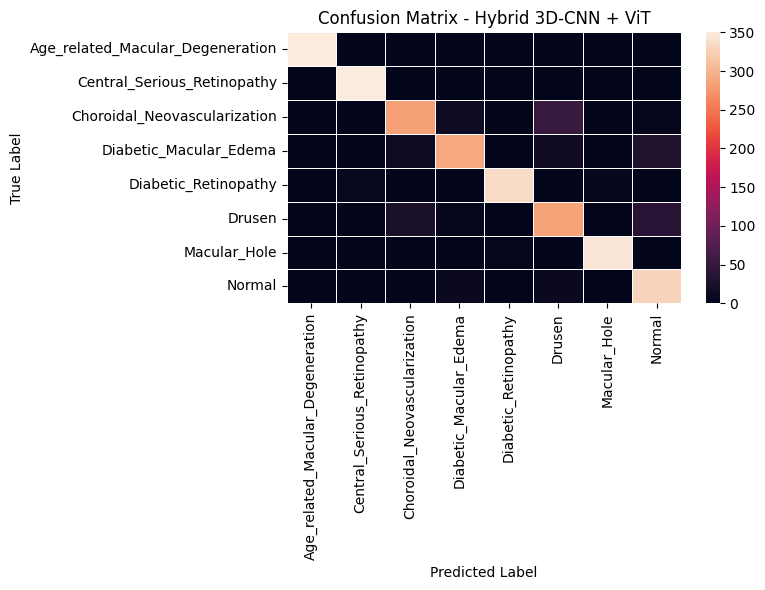

Classification Report:
                                  precision    recall  f1-score   support

Age_related_Macular_Degeneration       1.00      1.00      1.00       350
     Central_Serious_Retinopathy       0.98      1.00      0.99       350
    Choroidal_Neovascularization       0.87      0.81      0.84       350
          Diabetic_Macular_Edema       0.92      0.83      0.87       350
            Diabetic_Retinopathy       0.99      0.96      0.97       350
                          Drusen       0.79      0.81      0.80       350
                    Macular_Hole       0.98      0.99      0.98       350
                          Normal       0.82      0.94      0.88       350

                        accuracy                           0.92      2800
                       macro avg       0.92      0.92      0.92      2800
                    weighted avg       0.92      0.92      0.92      2800



In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix (no annotations, 'magma' or 'rocket' cmap)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=False,  # No text annotations inside boxes
    cmap='rocket',  # Use 'rocket' or 'magma' for similar coloring
    xticklabels=class_names,
    yticklabels=class_names,
    cbar=True,
    linewidths=0.5,
    linecolor='white'
)
plt.title('Confusion Matrix - Hybrid 3D-CNN + ViT')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Optional: Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


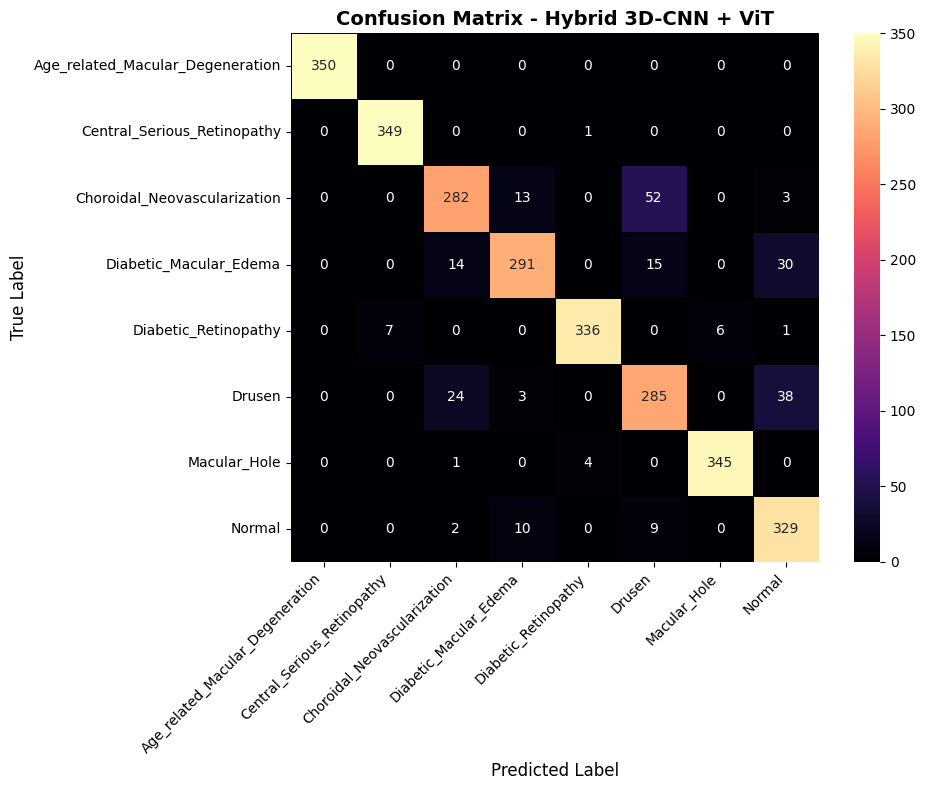

Classification Report:
                                  precision    recall  f1-score   support

Age_related_Macular_Degeneration       1.00      1.00      1.00       350
     Central_Serious_Retinopathy       0.98      1.00      0.99       350
    Choroidal_Neovascularization       0.87      0.81      0.84       350
          Diabetic_Macular_Edema       0.92      0.83      0.87       350
            Diabetic_Retinopathy       0.99      0.96      0.97       350
                          Drusen       0.79      0.81      0.80       350
                    Macular_Hole       0.98      0.99      0.98       350
                          Normal       0.82      0.94      0.88       350

                        accuracy                           0.92      2800
                       macro avg       0.92      0.92      0.92      2800
                    weighted avg       0.92      0.92      0.92      2800



In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='magma',      # colormap similar to your image
    xticklabels=class_names, 
    yticklabels=class_names, 
    cbar=True,         # show colorbar
    linewidths=0.5,    # thin lines between cells
    linecolor='black', # line color
    square=True        # keep cells square
)

plt.title('Confusion Matrix - Hybrid 3D-CNN + ViT', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha="right")  # rotate labels for readability
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Optional: Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

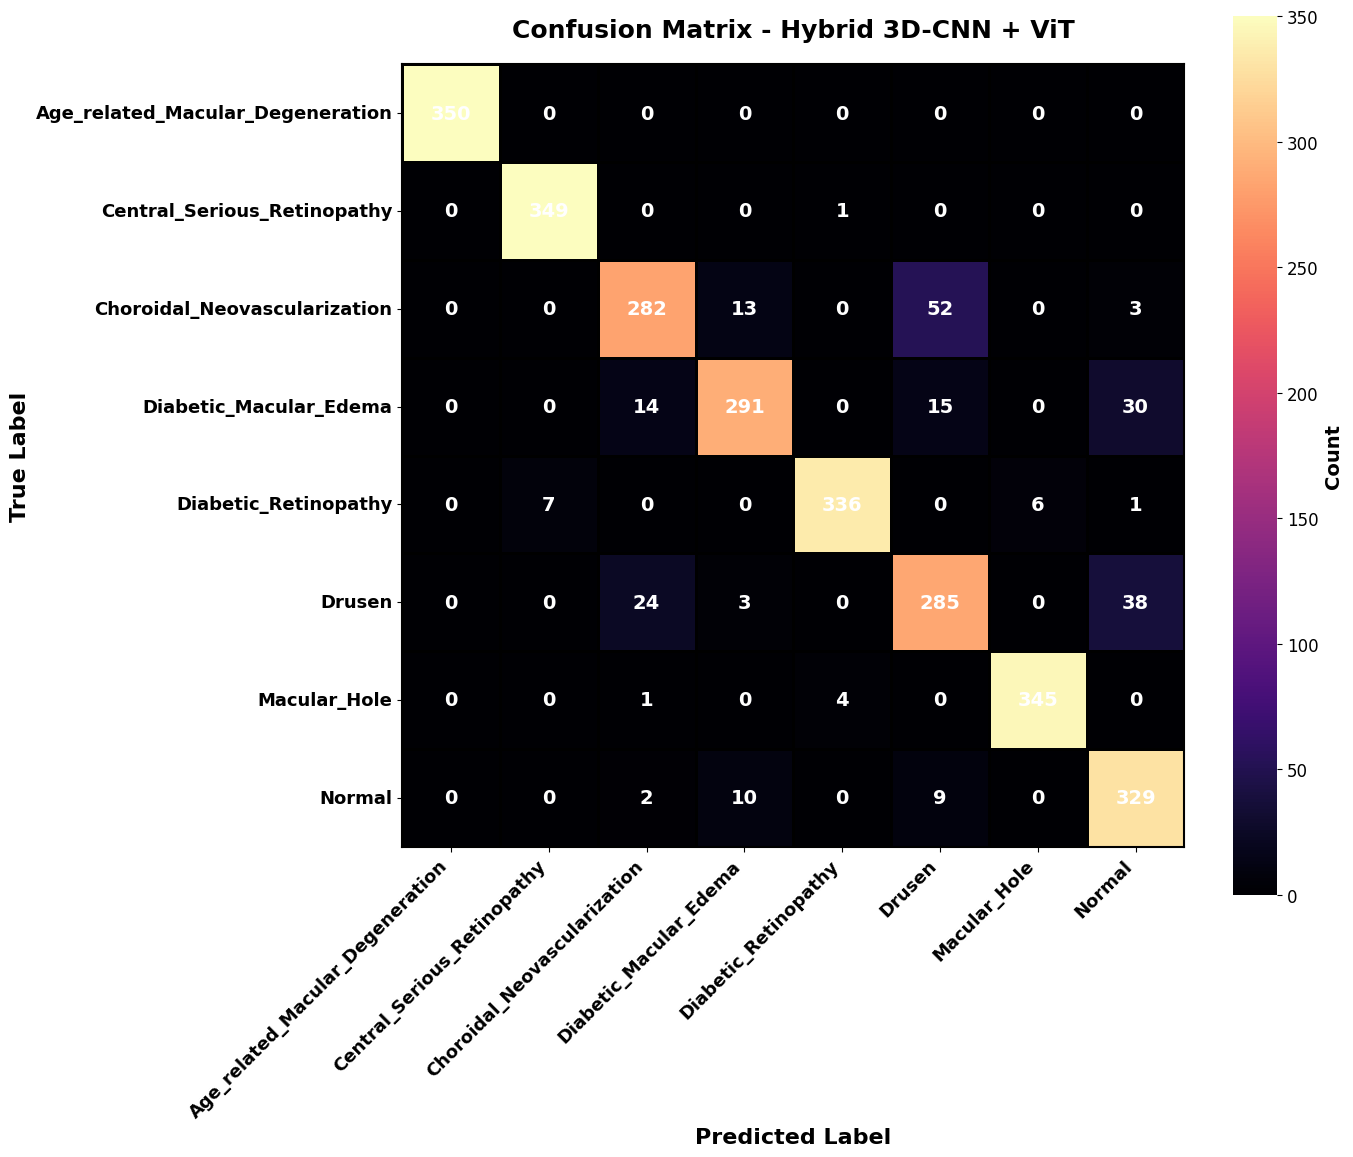

Classification Report:
                                  precision    recall  f1-score   support

Age_related_Macular_Degeneration       1.00      1.00      1.00       350
     Central_Serious_Retinopathy       0.98      1.00      0.99       350
    Choroidal_Neovascularization       0.87      0.81      0.84       350
          Diabetic_Macular_Edema       0.92      0.83      0.87       350
            Diabetic_Retinopathy       0.99      0.96      0.97       350
                          Drusen       0.79      0.81      0.80       350
                    Macular_Hole       0.98      0.99      0.98       350
                          Normal       0.82      0.94      0.88       350

                        accuracy                           0.92      2800
                       macro avg       0.92      0.92      0.92      2800
                    weighted avg       0.92      0.92      0.92      2800



In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot with larger size and better visibility
plt.figure(figsize=(14, 12))  # Increased figure size
ax = sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='magma',      # colormap similar to your image
    xticklabels=class_names, 
    yticklabels=class_names, 
    cbar=True,         # show colorbar
    linewidths=1.0,    # thicker lines between cells for better visibility
    linecolor='black', # line color
    square=True,       # keep cells square
    annot_kws={"size": 14, "weight": "bold", "color": "white"}  # Bold white numbers
)

# Make all text bold and more visible
plt.title('Confusion Matrix - Hybrid 3D-CNN + ViT', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=16, fontweight='bold')

# Make class labels bold, larger, and rotated for readability
plt.xticks(rotation=45, ha="right", fontsize=13, fontweight="bold")
plt.yticks(rotation=0, fontsize=13, fontweight="bold")

# Adjust colorbar label
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('Count', fontsize=14, fontweight='bold')

# Enhance the grid for better visibility
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1.5)

plt.tight_layout()
plt.show()

# Optional: Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

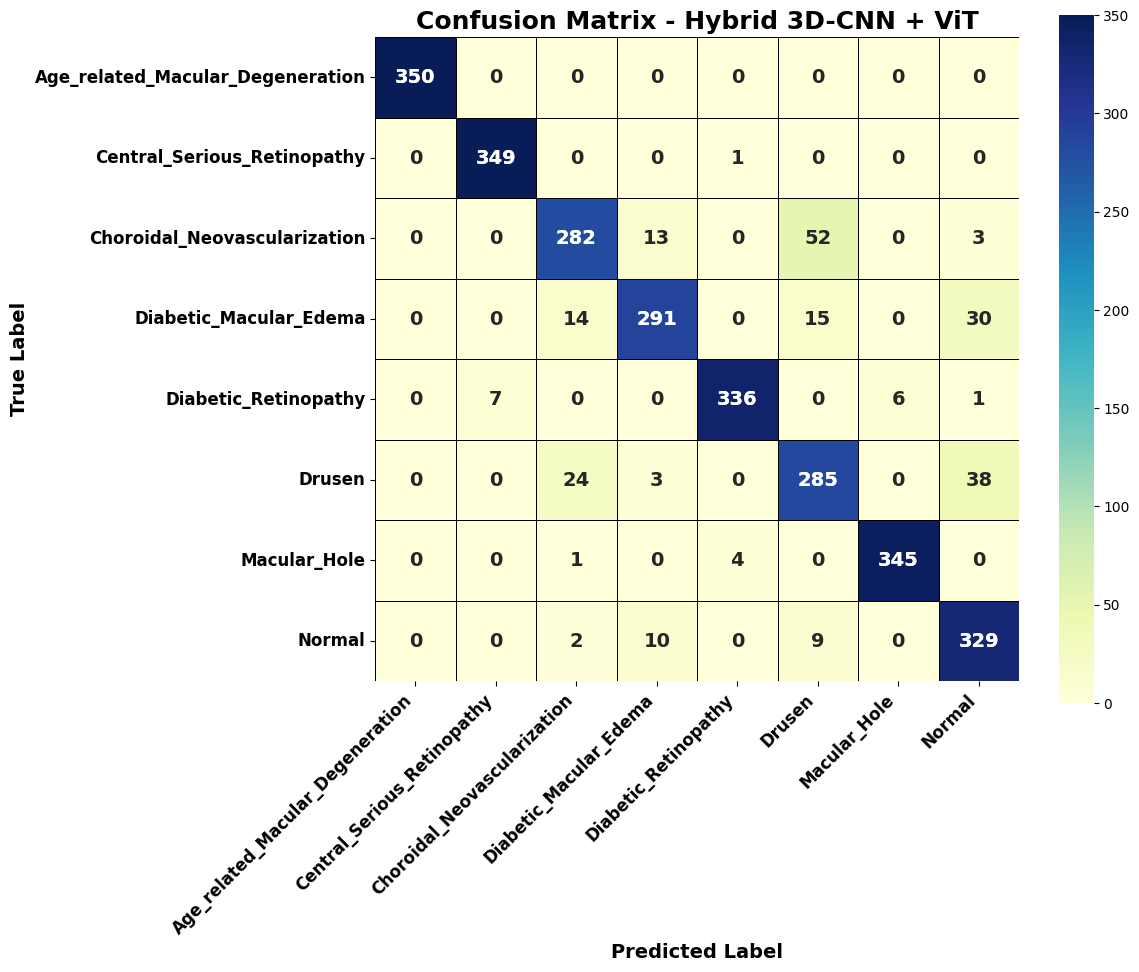

Classification Report:
                                  precision    recall  f1-score   support

Age_related_Macular_Degeneration       1.00      1.00      1.00       350
     Central_Serious_Retinopathy       0.98      1.00      0.99       350
    Choroidal_Neovascularization       0.87      0.81      0.84       350
          Diabetic_Macular_Edema       0.92      0.83      0.87       350
            Diabetic_Retinopathy       0.99      0.96      0.97       350
                          Drusen       0.79      0.81      0.80       350
                    Macular_Hole       0.98      0.99      0.98       350
                          Normal       0.82      0.94      0.88       350

                        accuracy                           0.92      2800
                       macro avg       0.92      0.92      0.92      2800
                    weighted avg       0.92      0.92      0.92      2800



In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Create a mask for the diagonal elements
mask = np.eye(cm.shape[0], dtype=bool)

# Plot with a lighter, more readable colormap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='YlGnBu',  # Better contrast; light yellow to blue
    xticklabels=class_names,
    yticklabels=class_names,
    cbar=True,
    linewidths=0.5,
    linecolor='black',
    square=True,
    annot_kws={"size": 14, "weight": "bold"}
)

# Make diagonal numbers white
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i == j:  # Diagonal elements
            ax.text(j+0.5, i+0.5, cm[i, j], 
                   ha="center", va="center", 
                   color="white", 
                   fontsize=14, fontweight="bold")

# Titles and labels
plt.title('Confusion Matrix - Hybrid 3D-CNN + ViT', fontsize=18, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')

# Make class labels bold and larger
plt.xticks(rotation=45, ha="right", fontsize=12, fontweight="bold")
plt.yticks(rotation=0, fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()

# Optional: Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

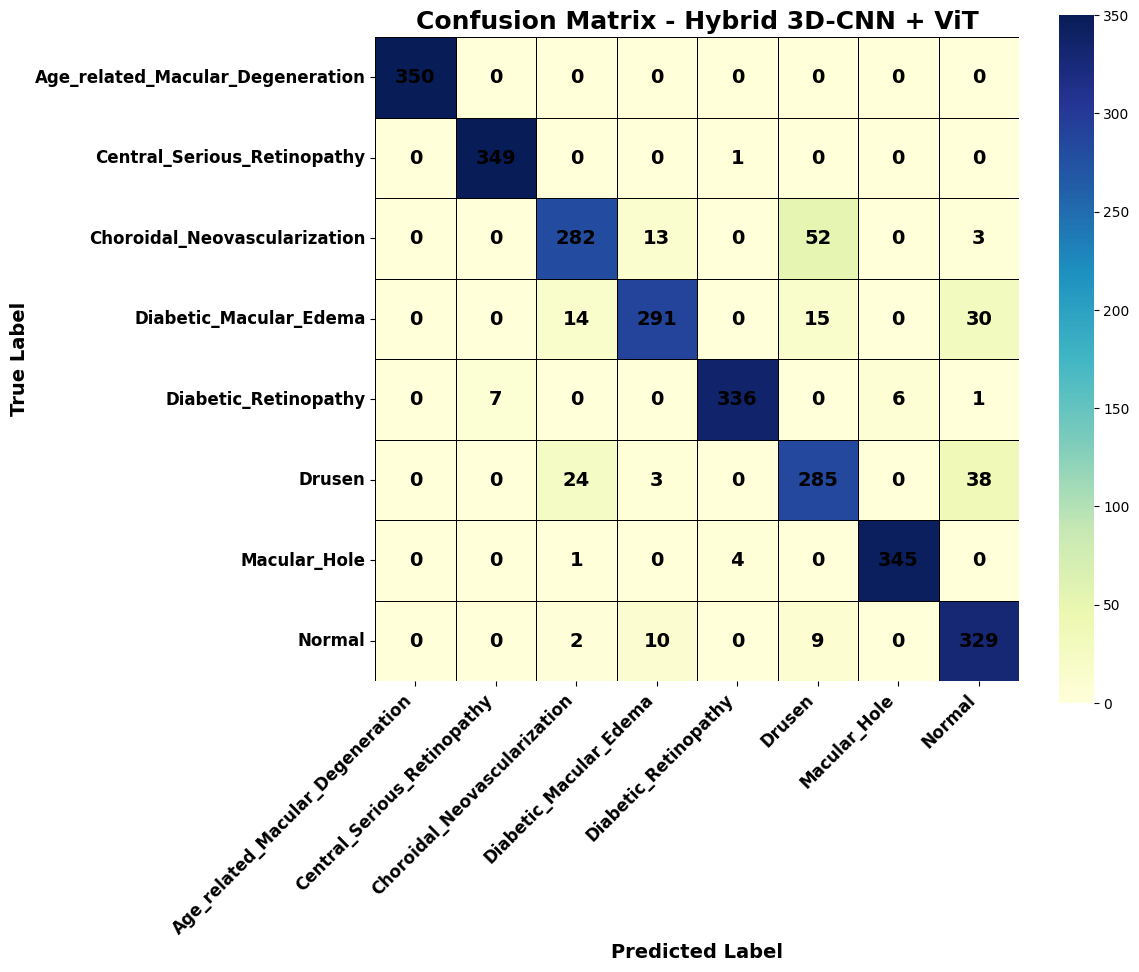

Classification Report:
                                  precision    recall  f1-score   support

Age_related_Macular_Degeneration       1.00      1.00      1.00       350
     Central_Serious_Retinopathy       0.98      1.00      0.99       350
    Choroidal_Neovascularization       0.87      0.81      0.84       350
          Diabetic_Macular_Edema       0.92      0.83      0.87       350
            Diabetic_Retinopathy       0.99      0.96      0.97       350
                          Drusen       0.79      0.81      0.80       350
                    Macular_Hole       0.98      0.99      0.98       350
                          Normal       0.82      0.94      0.88       350

                        accuracy                           0.92      2800
                       macro avg       0.92      0.92      0.92      2800
                    weighted avg       0.92      0.92      0.92      2800



In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot with a lighter, more readable colormap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='YlGnBu',  # Better contrast; light yellow to blue
    xticklabels=class_names,
    yticklabels=class_names,
    cbar=True,
    linewidths=0.5,
    linecolor='black',
    square=True,
    annot_kws={"size": 14, "weight": "bold", "color": "black"}
)

# Titles and labels
plt.title('Confusion Matrix - Hybrid 3D-CNN + ViT', fontsize=18, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')

# Make class labels bold and larger
plt.xticks(rotation=45, ha="right", fontsize=12, fontweight="bold")
plt.yticks(rotation=0, fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()

# Optional: Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

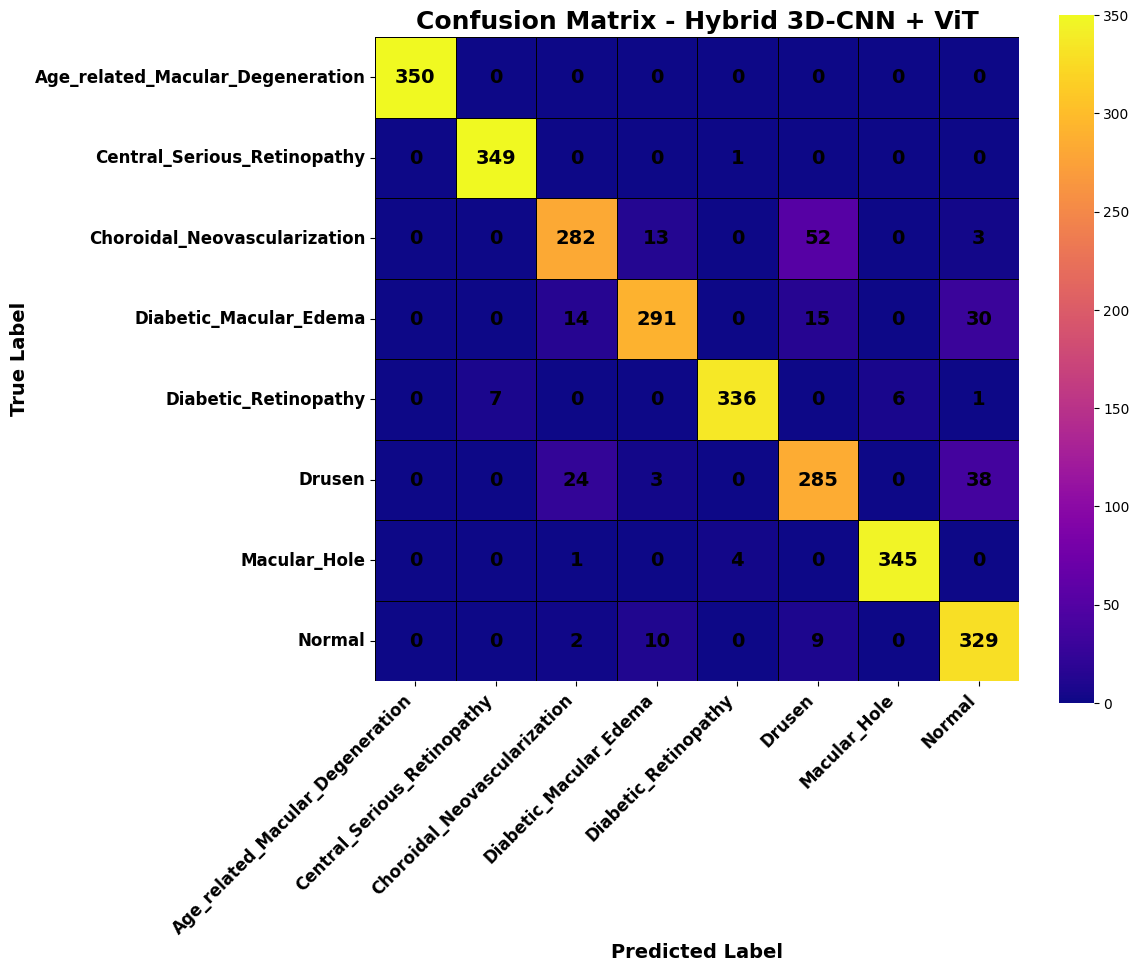

Classification Report:
                                  precision    recall  f1-score   support

Age_related_Macular_Degeneration       1.00      1.00      1.00       350
     Central_Serious_Retinopathy       0.98      1.00      0.99       350
    Choroidal_Neovascularization       0.87      0.81      0.84       350
          Diabetic_Macular_Edema       0.92      0.83      0.87       350
            Diabetic_Retinopathy       0.99      0.96      0.97       350
                          Drusen       0.79      0.81      0.80       350
                    Macular_Hole       0.98      0.99      0.98       350
                          Normal       0.82      0.94      0.88       350

                        accuracy                           0.92      2800
                       macro avg       0.92      0.92      0.92      2800
                    weighted avg       0.92      0.92      0.92      2800



In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='plasma',  # Use 'plasma' or 'inferno' – lighter than 'magma'
    xticklabels=class_names,
    yticklabels=class_names,
    cbar=True,
    linewidths=0.5,
    linecolor='black',
    square=True,
    annot_kws={"size": 14, "weight": "bold", "color": "black"}
)

# Titles and labels
plt.title('Confusion Matrix - Hybrid 3D-CNN + ViT', fontsize=18, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')

# Make class labels bold and larger
plt.xticks(rotation=45, ha="right", fontsize=12, fontweight="bold")
plt.yticks(rotation=0, fontsize=12, fontweight="bold")

# Optional: Adjust colorbar range to prevent very dark colors
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 50, 100, 150, 200, 250, 300, 350])
cbar.set_ticklabels(['0', '50', '100', '150', '200', '250', '300', '350'])

plt.tight_layout()
plt.show()

# Optional: Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Prediction + Explainable AI

### run these 3 cell sequentially for prediction and explainable AI output. this will run our main model with highest oerformence which is hybrid_3dcnn_vit_model.pth. that's out novelty model as well. 



In [1]:
import os, time, math, random
from typing import List, Tuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from PIL import Image, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt

from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam import EigenCAM



from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

import torchvision.transforms as T
from torchvision.models import vit_b_16, ViT_B_16_Weights


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import time
import numpy as np
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
# Model definitions
# --------------------
from torchvision.models import vit_b_16, ViT_B_16_Weights

class Small3DCNN(nn.Module):
    def __init__(self, in_ch=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(in_ch, 16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool3d((1,2,2)),

            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool3d((2,2,2)),

            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),

            nn.AdaptiveAvgPool3d((1,1,1))
        )
    def forward(self, x):
        x = self.net(x)
        return x.flatten(1)

class Hybrid3DViT(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
        vit_dim = self.vit.heads.head.in_features
        for p in self.vit.parameters():
            p.requires_grad = False
        self.vit.heads = nn.Identity()

        self.cnn3d = Small3DCNN(in_ch=1)
        cnn_dim = 64

        self.classifier = nn.Sequential(
            nn.Linear(vit_dim + cnn_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    def forward(self, vit_img, vol3d):
        f2d = self.vit(vit_img)
        f3d = self.cnn3d(vol3d)
        f   = torch.cat([f2d, f3d], dim=1)
        return self.classifier(f)

# --------------------
# Load trained model (checkpoint)
# --------------------
checkpoint = torch.load("hybrid_3dcnn_vit_model.pth", map_location=device)

# Get class info from checkpoint if available
if "class_names" in checkpoint:
    class_names = checkpoint["class_names"]
    num_classes = len(class_names)
    print("Loaded class names from checkpoint:", class_names)
else:
    test_dir = "dataset/test"
    class_names = sorted(os.listdir(test_dir))
    num_classes = len(class_names)
    print("Detected class names from folder:", class_names)

# Rebuild model with correct num_classes
model = Hybrid3DViT(num_classes).to(device)
model.load_state_dict(checkpoint["model_state_dict"])  # ✅ FIX
model.eval()

# --------------------
# Preprocessing utils
# --------------------
vit_weights = ViT_B_16_Weights.IMAGENET1K_V1
vit_transform = vit_weights.transforms()

volume_size = 128
to_tensor_gray = T.Compose([
    T.Resize((volume_size, volume_size)),
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])

def make_pseudo_volume(img_pil, depth: int = 4):
    slices = [
        img_pil,
        img_pil.transpose(Image.FLIP_LEFT_RIGHT),
        img_pil.rotate(10),
        ImageEnhance.Contrast(img_pil).enhance(1.3)
    ]
    slices = slices[:depth]
    slice_tensors = [to_tensor_gray(s) for s in slices]
    return torch.stack(slice_tensors, dim=1)   # [1,D,H,W]

Loaded class names from checkpoint: ['Age_related_Macular_Degeneration', 'Central_Serious_Retinopathy', 'Choroidal_Neovascularization', 'Diabetic_Macular_Edema', 'Diabetic_Retinopathy', 'Drusen', 'Macular_Hole', 'Normal']


Predicted class: Macular_Hole (0.99)


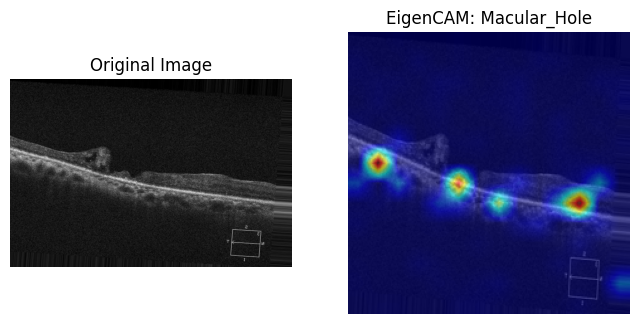

In [3]:
# Cell 2: Prediction + EigenCAM visualization (for ViT branch)


class ViTWrapper(nn.Module):
    """
    Wrapper so EigenCAM can work with Hybrid3DViT.
    It only takes vit_img as input, while holding vol3d fixed.
    """
    def __init__(self, hybrid_model, fixed_vol3d):
        super().__init__()
        self.hybrid_model = hybrid_model
        self.fixed_vol3d = fixed_vol3d

    def forward(self, vit_img):
        return self.hybrid_model(vit_img, self.fixed_vol3d)

def predict_and_explain(img_path):
    img = Image.open(img_path).convert("RGB")

    # Prepare inputs
    vit_img = vit_transform(img).unsqueeze(0).to(device)   # [1,3,224,224]
    vol3d   = make_pseudo_volume(img).unsqueeze(0).to(device)  # [1,1,D,H,W]

    # Prediction
    with torch.no_grad():
        outputs = model(vit_img, vol3d)
        probs = torch.softmax(outputs, dim=1)[0]
        pred_class = probs.argmax().item()
    
    print(f"Predicted class: {class_names[pred_class]} ({probs[pred_class]:.2f})")

    # --------------------
    # EigenCAM
    # --------------------
    wrapped_model = ViTWrapper(model, vol3d)

    # Use conv_proj (ViT patch embedding conv) as target layer
    target_layers = [wrapped_model.hybrid_model.vit.conv_proj]

    cam = EigenCAM(model=wrapped_model, target_layers=target_layers)

    grayscale_cam = cam(input_tensor=vit_img)[0, :]
    rgb_img = np.array(img.resize((224,224))).astype(np.float32) / 255.0
    cam_img = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Show results
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(cam_img)
    plt.title(f"EigenCAM: {class_names[pred_class]}")
    plt.axis("off")
    plt.show()

# --------------------
# Example usage
# --------------------
test_img_path = "dataset/test/Macular_Hole/mh_test_1101.jpg"

predict_and_explain(test_img_path)
